## Caso de Uso: Pronóstico de la demanda de un negocio de Restauración mediante de análisis Series Temporales. 

**_Descripción_**

El presente estudio corresponde al Análisis de los datos de un negocio real de un Bar-Restaurant especializado en Hamburguesas. Los datos se encuentran comprendidos entre julio del 2023 y febrero del 2025.  La información proviene directamente del sistema contable utilizado por el propio negocio y corresponde además a uno de los locales.


**_Objetivo General_:**

El presente trabajo tiene como objetivo general, la predicción de los ingresos por ventas futuras que podría tener el negocio.


**_Objetivos Específicos_:**
 - Realizar Limpieza y Preprocesamiento de los datos.
 - Realizar Análisis Exploratorio de los Datos, que puedan arrojar información descriptiva de la población estudiada.
 - Modelar mediante análisis de Series Temporales el pronóstico de las ventas futuras.
 - Validar el modelo seleccionado.

#### **Carga Inicial:**

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go 

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics
import itertools


#### **1. Recopilación de Datos**

***1.1. Carga de Histórico de Ventas:***

In [3]:
df_hystoric = pd.read_csv('./data-sets/data_historico_ventas.csv', encoding='utf-8', decimal=',')
df_hystoric.head(3)

,No. de Operación,Fecha/Hora,Mercancía,Grupo de la Mercancía,Nombre de socio,Entidad,Operador,Grupo del Operador,Cantidad,Medida,Precio de Venta,Importe,Suma Total
0,4590,7/4/2023 11:53,Doble Hamburguesa Cerdo,CERDO HAMBURGUESAS,SocioSistema,Piso de venta,Lisi,Administrativos,1.0,U,492.0,492.0,492.0
1,4590,7/4/2023 11:53,Suero de Helado,BATIDOS,SocioSistema,Piso de venta,Lisi,Administrativos,1.0,U,335.0,335.0,335.0
2,4591,7/4/2023 12:00,Limonada,JUGOS,SocioSistema,Piso de venta,Lisi,Administrativos,1.0,U,150.0,150.0,150.0


***1.2. Carga de Días Laborables y Festividades:***

In [4]:
df_day = pd.read_csv('./data-sets/dias_laborables_festivos_cuba.csv', encoding='utf-8')

_NOTA: Se procederá en el siguientes apartados a mezclar los datos luego del renombrado de las columnas en dataframe de Histórico de Ventas._

#### **2. Limpieza y procesamiento de datos:**

**2.1. Análisis del tipo de datos de las variables.**

In [5]:
df_hystoric.dtypes

No. de Operación           int64
Fecha/Hora                object
Mercancía                 object
Grupo de la Mercancía     object
Nombre de socio           object
Entidad                   object
Operador                  object
Grupo del Operador        object
Cantidad                 float64
Medida                    object
Precio de Venta          float64
Importe                  float64
Suma Total               float64
dtype: object

Resultados:
- Es observable que la variable **Fecha/Hora** no se encuentra formateada correctamente.
- Las variables **Cantidad, Precio de Venta, Importe y Suma Total** se encuentran en un formato númerico, que por características del negocio estaría correcto.
- El nombrado de las variables( importadas desde el sistema contable del negocio), no se encuentra en snake_case, por lo que es recomendable modificarlo para que coincida con el estándar de PEP8.

***2.1.1. Transformando variable Fecha.***

In [6]:
df_hystoric['Fecha/Hora'] = pd.to_datetime(df_hystoric['Fecha/Hora'])

***2.1.2. Renombrando variables en el data-set de Histórico de Ventas.***

In [7]:
names = {
    'No. de Operación': 'operacion',
    'Fecha/Hora': 'fecha',
    'Mercancía': 'mercancia',
    'Grupo de la Mercancía': 'grupo_mercancia',
    'Nombre de socio': 'nombre_socio',
    'Entidad': 'entidad',
    'Operador': 'operador',
    'Grupo del Operador': 'grupo_operador',
    'Cantidad': 'cantidad',
    'Medida': 'medida',
    'Precio de Venta': 'precio_venta',
    'Importe': 'importe',
    'Suma Total': 'suma_total'
}

df_hystoric = df_hystoric.rename(columns=names)


***2.1.3. Integración de Datos.***

In [8]:
df_day['fecha'] = pd.to_datetime(df_day['fecha'])

# Al poseer formato diferentes en la fechas se procede al mezclado de los dataset de la siguiente forma:
df = pd.merge(df_hystoric, df_day, left_on=pd.to_datetime(df_hystoric['fecha']).dt.date, right_on=pd.to_datetime(df_day['fecha']).dt.date)

# Se generan columnas adicionales por lo que se modifica y eliminan las nuevas generadas
df.rename(columns={'fecha_x':'fecha'}, inplace=True)
df = df.drop(columns=['key_0', 'fecha_y'])

# Se decide por convención y en aras de evitar valores nulos los días que no son festivos renombrarlos con 'No Festivo'.
df['nombre_festivo'].fillna('No Festivo', inplace=True)

df.head()

,operacion,fecha,mercancia,grupo_mercancia,nombre_socio,entidad,operador,grupo_operador,cantidad,medida,precio_venta,importe,suma_total,dia_semana,tipo_dia,nombre_festivo
0,4590,2023-07-04 11:53:00,Doble Hamburguesa Cerdo,CERDO HAMBURGUESAS,SocioSistema,Piso de venta,Lisi,Administrativos,1.0,U,492.0,492.0,492.0,Martes,Laborable,No Festivo
1,4590,2023-07-04 11:53:00,Suero de Helado,BATIDOS,SocioSistema,Piso de venta,Lisi,Administrativos,1.0,U,335.0,335.0,335.0,Martes,Laborable,No Festivo
2,4591,2023-07-04 12:00:00,Limonada,JUGOS,SocioSistema,Piso de venta,Lisi,Administrativos,1.0,U,150.0,150.0,150.0,Martes,Laborable,No Festivo
3,4592,2023-07-04 12:06:00,Sencilla Cerdo,CERDO HAMBURGUESAS,SocioSistema,Piso de venta,Lisi,Administrativos,2.0,U,290.0,580.0,580.0,Martes,Laborable,No Festivo
4,4592,2023-07-04 12:06:00,Suero de Helado,BATIDOS,SocioSistema,Piso de venta,Lisi,Administrativos,2.0,U,335.0,670.0,670.0,Martes,Laborable,No Festivo


**2.2. Análisis preliminar.**

In [9]:
df.describe(include="all")

,operacion,fecha,mercancia,grupo_mercancia,nombre_socio,entidad,operador,grupo_operador,cantidad,medida,precio_venta,importe,suma_total,dia_semana,tipo_dia,nombre_festivo
count,2.485820e+05,248582,248582,248582,248582,248582,248582,248582,248582.000000,248582,248582.000000,248582.000000,248582.000000,248582,248582,248582
unique,NaN,NaN,631,28,325,2,24,3,NaN,7,NaN,NaN,NaN,7,3,12
top,NaN,NaN,Croquetas de Jamon,Grupo para uso del sistema,!Cliente,Piso de venta,Yari,Administrativos,NaN,U,NaN,NaN,NaN,Domingo,Laborable,No Festivo
freq,NaN,NaN,11249,35848,156103,248577,45218,164081,NaN,231731,NaN,NaN,NaN,45829,155094,241757
mean,3.559046e+05,2024-05-03 16:55:16.612948736,NaN,NaN,NaN,NaN,NaN,NaN,2.827549,NaN,410.481717,672.370966,672.481754,NaN,NaN,NaN
min,4.590000e+03,2023-07-04 11:53:00,NaN,NaN,NaN,NaN,NaN,NaN,0.001000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,2.530000e+04,2023-12-02 15:04:00,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,195.000000,250.000000,250.000000,NaN,NaN,NaN
50%,4.379300e+04,2024-05-04 23:03:00,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,350.000000,495.000000,495.000000,NaN,NaN,NaN
75%,1.063736e+06,2024-10-04 22:02:00,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,550.000000,850.000000,850.000000,NaN,NaN,NaN
max,1.079486e+06,2025-02-28 23:51:00,NaN,NaN,NaN,NaN,NaN,NaN,2500.000000,NaN,18150.000000,123000.000000,123000.000000,NaN,NaN,NaN


Resultados:

- En el período analizado se realizaron 248582 ventas de productos.
- La población analizada se encuentra enmarcada entre  julio del 2023 hasta febrero del 2025.
- El producto **Croquetas de Jamon** ha sido el que más demanda ha tenido, lo que pudiera indicar que al ser un entrante, los clientes visitan el lugar para hacer estancia y compartir tiempo en el lugar.
- El campo **nombre_socio** muestra que el más representativo es !Cliente con una frecuencia que representa un 62% del total aproximadamente, lo que pudiera indicar que existen otras categorías que también impactan sobre las ventas, aspecto que es necesario analizar.
- La variable Cantidad muestra un rango que pudiera detonar la presencia de valores atípicos. Y es necesario prestar importante interés en el mínimo.
- El alto valor de la desviación estándar en **importe y suma_total**, refleja los dispersos que se encuentran los valores, lo que puede denotar que la clientela que acude al local posee diferentes popder adquisitivo y por tanto realizan consumisiones variadas.
- Es necesario analizar el impacto que pudiera tener variables como:**entidad, operador, grupo_operador**, y en caso de no ser relevancia proceder a eliminarlas.


**2.3. Análisis de Duplicados**

In [10]:
print(f"CANTIDAD DUPLICADOS: {df.duplicated().sum()}")
df[df.duplicated()].head(5)

CANTIDAD DUPLICADOS: 7505


,operacion,fecha,mercancia,grupo_mercancia,nombre_socio,entidad,operador,grupo_operador,cantidad,medida,precio_venta,importe,suma_total,dia_semana,tipo_dia,nombre_festivo
49864,21179,2023-10-29 20:40:00,Cerveza Calatrava 330ml,Grupo para uso del sistema,Cliente2,Piso de venta,Carlos caja,Administrativos,2.0,U,250.0,500.0,500.0,Domingo,Fin de semana,No Festivo
170782,56959,2024-08-29 17:10:00,Croquetas de Jamon,ENTRANTES,!Cliente,Piso de venta,Hazeem,Dependientes,1.0,U,530.0,530.0,530.0,Jueves,Laborable,No Festivo
170793,56964,2024-08-29 18:32:00,Mojito,COCTELES,!Cliente,Piso de venta,Hazeem,Dependientes,1.0,U,400.0,400.0,400.0,Jueves,Laborable,No Festivo
170796,56964,2024-08-29 18:32:00,Con Jamon y Queso Cerdo,CERDO HAMBURGUESAS,!Cliente,Piso de venta,Hazeem,Dependientes,1.0,U,835.0,835.0,835.0,Jueves,Laborable,No Festivo
170797,56964,2024-08-29 18:32:00,Refresco PEPSI Cola,Grupo para uso del sistema,!Cliente,Piso de venta,Hazeem,Dependientes,1.0,U,300.0,300.0,300.0,Jueves,Laborable,No Festivo


Resultados:
 
El análisis muestra que existen 7505 valores duplicados, lo que puede resultar un comportamiento no esperado en un dataset extraído directamente de un sistema contable. Se realiza un analálisis detallado del dataset, y se puede validar que existen operaciones que tienen registro de ventas de al menos un producto repetidos. Lo que puede indicar un comportamiento ánomalo del sistema, o una manipulación incorrecta por parte de los operadores, o quizás es un comportamiento propio del modelo de negocio. 

NOTA: Se pudo validar con los especialistas del negocio que el comportamiento anteriormente mencionado está dado a detalles técnicos del sistema, ya que no permite acumular un mismo producto cuando es entrado al sistema en momentos diferente dentro de un mismo ticket. Este comportamiento ocurre a partir de que existen clientes que hacen un pedido de un producto en un primer momento y luego realizan nuevamente otro pedido.  

Una vez puntualizado con los especialistas, se decide mantener los registros que poseen estas característica por su importancia en los análisis posteriores.

**2.4. Detección de Oultiers.**

**2.4.1. Outliers columnas númericas.**

CANTIDAD Variables Numéricas: 4


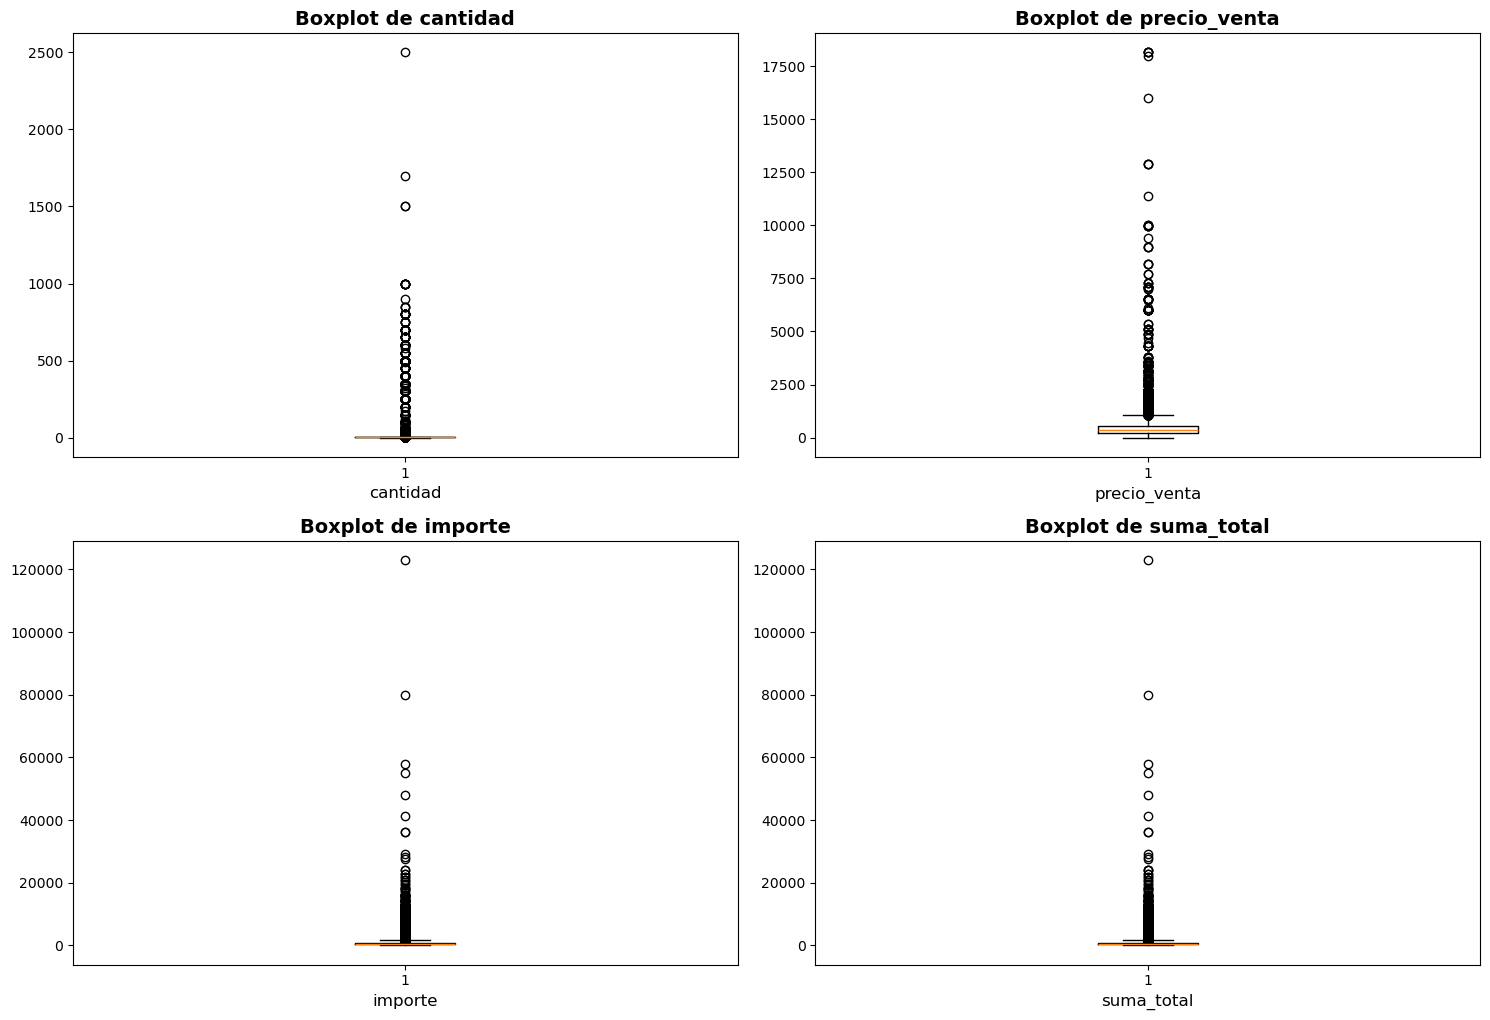

In [11]:
# Se excluye la columna de operacion ya que es una variable identificativa y no aporta valor para el análisis de atípicos.
columns_num = df.select_dtypes(include=['float']).columns
print(f'CANTIDAD Variables Numéricas: {len(columns_num)}')

fig, axes = plt.subplots(len(columns_num), 2, figsize=(15, 20)) 
axes = axes.flatten() 
for i, col in enumerate(columns_num):
    axes[i].boxplot(df[col], vert=True)
    axes[i].set_title(f"Boxplot de {col}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    
for i in range(len(columns_num), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Resultados:
- Es apreciable que todas las variables númericas poseen valores atípicos.
- Los valores atípicos en la variable **cantidad**, pudiera estar sujeto a compras mayoristas o como resultado de ofertas especiales. Llevando a concluir que este tipo de opciones puede tener un resultado favorable en el negocio.
- Los precios atípicos en la variable **precio_venta**, pudiera indicar la presencia de productos premiums, y sería interesante comprobar el comportamiento de los clientes frente a estos productos.
- El alto nivel de valores atípicos de la variable **total** en comparación con el resto, puede deberse a clientes que compran en grandes cantidades, o clientes que compran productos de alto valor. Indicando cómo se comentaba en el Análisis Preliminar, la posible presencia de clientes de alto estándar.
- Los oultiers detectados no son datos érroneos una vez consultados a los especialistas, y además forman parte del negocio, lo que cobra sentido no modificarlos y trabajar con ellos.
 

**2.4.2. Análisis de valores atípicos en variables categóricas.**

CANTIDAD Variables Categóricas: 10


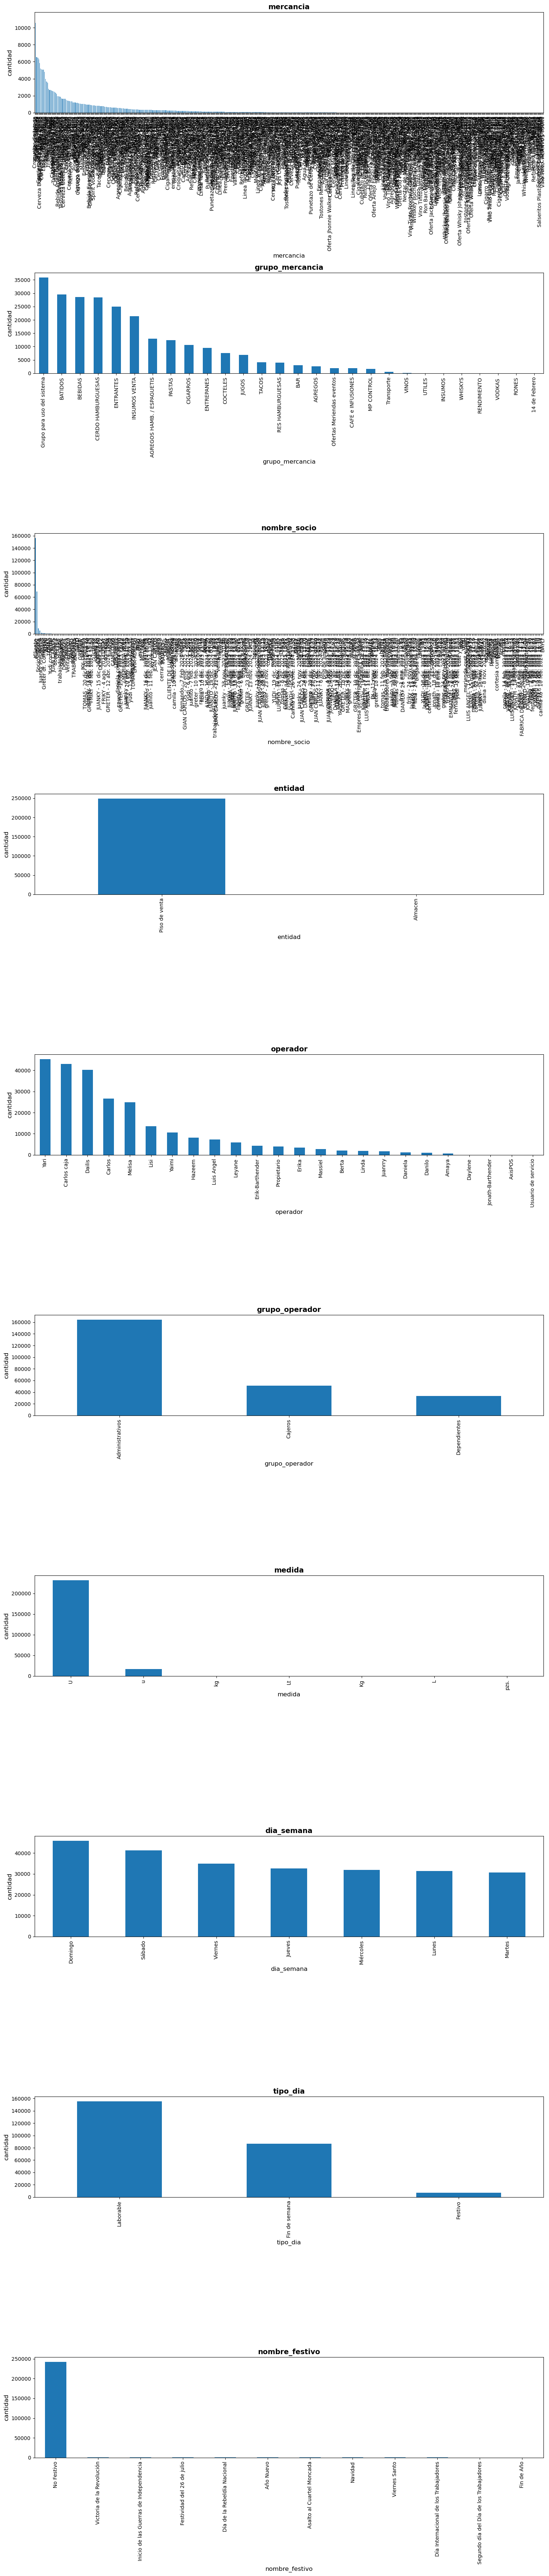

In [12]:
columns_categ = df.select_dtypes(include=["object"]).columns
print(f'CANTIDAD Variables Categóricas: {len(columns_categ)}')
fig, axes = plt.subplots(len(columns_categ), 1, figsize=(15, 7*len(columns_categ))) 
axes = axes.flatten() 
for i, col in enumerate(columns_categ):
    # Las variables con mayor cantidad de categorias pudieran filtrarse, pero se ha dejado con el proposito de entender como están distribuidas de manera general.    
    value_count = df[col].value_counts()
    value_count.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{col}", fontsize=14,  fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel("cantidad", fontsize=12)    
        
for i in range(len(columns_categ), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

Resultados:
- El análisis en la variable **mercancia** indica que existe un gran número de productos con una baja frecuencia de compra, lo que pudiera indicar que son productos que se venden poco o simplementes mercancias que se sacaron en ofertas promociones.
- El **grupo_mercancia** muestra algunas categorías poco comunes como Transporte y 14_febrero, este último puede indicar una oferta o promoción espcíficamente para esa fecha. En el caso de Transporte es una categoría para uso del interno del negocio, por lo que no aporta valor a los análisis posteriores, y pudiera sesgar los datos. En previa consulta con los especialistas se procederá a eliminar.
- La variabe **nombre_socio** muestra un comportamiento anomálo, representanto una diversidad en las personas que registran datos en el mismo. Este tema fue informado a los especialistas, aspecto del cuál están al tanto, y desde hace un tiempo trabajan en erradicar. Para esta variable los valores asociados a _clientes_, son los que serán utilizados y tenidos en cuenta para los posteriores análisis.
- Las variables **operador_ y _grupo_operador** serán eliminadas al no ser significativas y de gran importancia para el análisis de negocio que se pretende realizar.
- La variable **medida** posee valores que representan unidades de cantidad y volumen, por lo que se puede deducir cómo en otras variables, que entre los registros existen productos que no fueron vendidos como parte de las ofertas del bar-restaurant. Previamente consultado con los especialistas, se procederá a eliminar las observaciones correspondientes.
- El análisis de **dia_semana**, muestra una distribución bastante uniforme, mostrando vetnas más elevadas durante el fin de semana, lo que es un comportamiento adecuado para este tipo de negocio.
- Las variables **tipo y nombre_festivo** siguen un comportamiento esperado, a partir de que los días laborables al ser mayor cantidad de días, son los que más ventas generan.


**2.4.3. Modificando el Dataset a partir de las observaciones anteriores_.**

In [13]:
print(f"Tamaño original: {len(df)}")
# Eliminando categorías de grupo_mercancia
df_update = df[(df['grupo_mercancia'] != 'Transporte') & (df['grupo_mercancia'] != 'Grupo para uso del sistema') & (df['grupo_mercancia'] != 'MP CONTROL')].reset_index(drop=True)
print(f"Tamaño modificado sin Transporte y Grupo para uso del sistema: {len(df_update)}")

# Eliminando nombre_socios que no corresponden a clientes reales.
df_update = df_update[df_update["nombre_socio"].str.contains("cliente|Cliente|domicilio", case=False, na=False)].reset_index(drop=True)
print(f"Tamaño modificado con solo clientes: {len(df_update)}")

# Eliminando columnas que no aportan valor de análisis (operador, grupo_operador, entidad)
df_update = df_update.drop(columns = ['operador','grupo_operador','entidad'])

# Eliminando Unidades de medidas que no corresponden con pedidos de clientes
df_update = df_update[df_update["medida"].str.contains("U|u", case=False, na=False)].reset_index(drop=True)
print(f"Tamaño modificado con solo Unidades: {len(df_update)}")


# Modificando la variable operacion de númerica a categórica, ya que es un valor identificativo de los ticket de compra y no cumple objetivo tratarla como número.fdsf
df_update['operacion'] = df_update['operacion'].astype("object")

Tamaño original: 248582
Tamaño modificado sin Transporte y Grupo para uso del sistema: 210456
Tamaño modificado con solo clientes: 191578
Tamaño modificado con solo Unidades: 191565


Resultados:
- El dataset original cuenta con 248,582 registros, lo que representa el total de operaciones registradas por el sistema, incluyendo todos los tipos de mercancías, unidades y tipos de clientes.
- Luego de eliminar las categorías técnicas en grupo_mercancia, específicamente 'Transporte', 'Grupo para uso del sistema' y 'MP CONTROL', el dataset se reduce a 210,456 registros. Este paso es crucial para centrar el análisis en productos efectivamente comercializados, eliminando grupos administrativos o no representativos del comportamiento del cliente final.
- Se procede a filtrar únicamente los registros que incluyen en el campo nombre_socio términos relacionados con clientes reales (cliente, Cliente, domicilio), reduciendo el conjunto a 191,578 registros. Este filtrado asegura que el análisis se enfoque únicamente en consumidores reales, descartando posibles registros internos o técnicos.
- Posteriormente, se filtran las unidades de medida para mantener solo aquellas relacionadas con unidades individuales (U, u), resultando en 191,565 registros. Este filtro permite descartar medidas de peso o volumen que podrían corresponder a abastecimiento o consumo interno, y no a ventas unitarias al cliente.
- Finalmente, la columna operación se transforma a tipo object, reconociendo que no debe ser interpretada como una variable numérica sino como un identificador categórico de ticket o transacción, clave para futuras agrupaciones o análisis de comportamiento por operación.

**2.4.3. Análisis de Nulos**

In [14]:
print(df.isnull().sum())

operacion          0
fecha              0
mercancia          0
grupo_mercancia    0
nombre_socio       0
entidad            0
operador           0
grupo_operador     0
cantidad           0
medida             0
precio_venta       0
importe            0
suma_total         0
dia_semana         0
tipo_dia           0
nombre_festivo     0
dtype: int64


Resultados:
- Se puede evidenciar que el dataset analizado no posee valores nulos

**2.5. Encoding**

_2.5.1. Cantidad de **valores únicos** en cada variable categórica._ 

In [15]:
for i, col in enumerate(df_update.select_dtypes(include=["object"]).columns):    
    value_count = df_update[col].value_counts()
    print(f'Columna {col}: {len(value_count)}')

Columna operacion: 55901
Columna mercancia: 338
Columna grupo_mercancia: 23
Columna nombre_socio: 11
Columna medida: 2
Columna dia_semana: 7
Columna tipo_dia: 3
Columna nombre_festivo: 12


In [16]:
df_update.tipo_dia.value_counts()

tipo_dia
Laborable        119443
Fin de semana     66678
Festivo            5444
Name: count, dtype: int64

In [17]:
# Codificando solo la categoría Festivo en la variable de tipo_dia  como binario, ya que puede ser utilizada como variable Exógena en los modelos de Series Temporales.
df_update['es_fin_semana'] = np.where(df_update['tipo_dia'] == 'Fin de semana', 1, 0)
df_update['es_festivo'] = np.where(df_update['tipo_dia'] == 'Festivo', 1, 0)


Resultados:
- El encoding solo se realiza sobre la variable tipo_dia, y mediante encoding binario, lo que permite obtener cuando el registro fue o no en días festivos, obviando las otras dos categorías de Laborables y Fin de semana.
- Se utilizó solo tipo_dia para el encoding ya que el resto no aporta valor para poder emplearlas como variable exógena en las series temporales. 


**2.6. Análisis de Colinealidad**

In [18]:
df_update.select_dtypes(include=['int', 'float']).corr()

# **_NOTA_********
# Se utiliza esta variante porque el mapa de calor, por alguna razón no muestra las correlaciones.
# ****************
# plt.figure(figsize=(20,10))
# sns.heatmap(df_num.corr(),annot=True,fmt='.2f',cmap='RdBu', linewidths=0.5)

,cantidad,precio_venta,importe,suma_total,es_fin_semana,es_festivo
cantidad,1.000000,-0.036519,0.598321,0.598317,0.009245,0.006338
precio_venta,-0.036519,1.000000,0.579328,0.579365,0.017482,-0.001209
importe,0.598321,0.579328,1.000000,0.999988,0.020583,0.005614
suma_total,0.598317,0.579365,0.999988,1.000000,0.020572,0.005611
es_fin_semana,0.009245,0.017482,0.020583,0.020572,1.000000,-0.124967
es_festivo,0.006338,-0.001209,0.005614,0.005611,-0.124967,1.000000


Resultados:
- Las variables **importe y suma_total** tienen una correlación casi perfecta (0.999988). Esto sugiere que, para los registros en este dataset, ambas columnas representan esencialmente el mismo valor o están altamente redundantes, por lo que podría ser conveniente considerar una sola de ellas en futuros modelos para evitar colinealidad.
- La variable **cantidad** muestra una correlación moderada positiva con importe y con suma_total. Esto indica que, como es de esperar, al aumentar la cantidad vendida, también aumenta el valor económico total de la operación, lo que valida la coherencia del registro de ventas.
- Es observable que la variable **suma_total** no es ortogonal con respecto a **precio_venta** y **cantidad**( que tiene una correlación positiva baja pero no nula, e indica que no necesariamente son redundantes), elemento a tener en cuenta para el desarrollo de futuros modelos.
- Las variables **es_festivo y es_fin_semana** no muestran correlaciones relevantes con ninguna otra variable. Esto es esperado, ya que se tratan de una variables exógenas categórica.

#### **3. Exploración y análisis de datos.**

**3.1. Productos de alta demanda.**

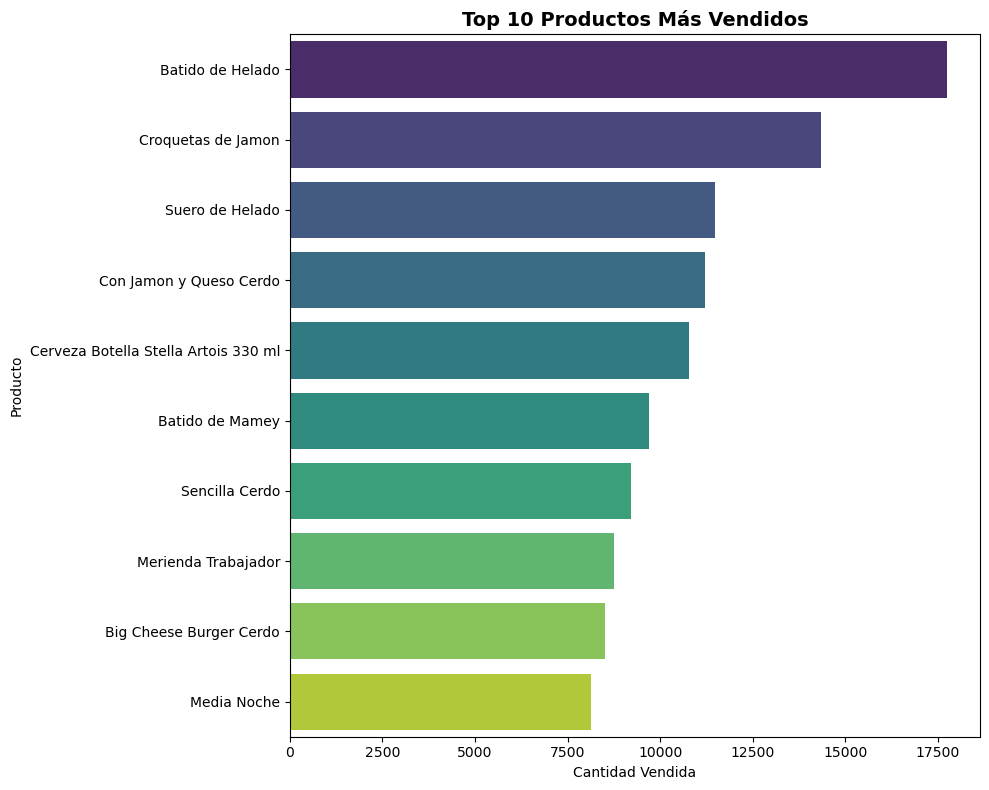

In [19]:
df_top = df_update.groupby('mercancia', as_index=False).agg({'cantidad':'sum'}).sort_values(by='cantidad', ascending=False).head(10)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_top, x='cantidad', y='mercancia', palette='viridis')
plt.title('Top 10 Productos Más Vendidos', fontsize=14, fontweight='bold')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Producto')
plt.tight_layout()
plt.show()



Resultados:
- El **"Batido de Helado"** se posiciona como el producto más vendido con diferencia significativa respecto al resto. Esto indica una alta demanda en productos fríos o de refrescantes, lo cual podría estar influenciado por el clima de calor o por la preferencia de los consumidores hacia productos rápidos y refrescantes.
- En el segundo y tercer lugar aparecen **"Croquetas de Jamón" y "Suero de Helado"**, productos también fáciles de consumir y de preparación ágil, lo que refuerza la idea de una preferencia por alimentos ligeros y de rápida salida.
- La diversidad de productos cárnicos como **"Con Jamón y Queso Cerdo", "Sencilla Cerdo" y "Big Cheese Burger Cerdo"** reflejan una demanda constante por opciones más consistentes, probablemente vinculadas a comidas principales como almuerzos o cenas.
- La presencia de bebidas como la **"Cerveza Botella Stella Artois 330 ml"** en el top 5 muestra que el consumo de productos alcohólicos también tiene un papel destacado en el negocio, especialmente en momentos de ocio o fines de semana.
- También destacan platos económicos y populares como la **"Merienda Trabajador" o la "Media Noche"**, lo que puede estar asociado al segmento de trabajadores locales o clientes habituales que buscan opciones accesibles.
- En resumen, el análisis de los productos más vendidos evidencia una combinación equilibrada entre productos de impulso (batidos, croquetas), productos cárnicos (platos fuertes), y bebidas alcohólicas, lo que sugiere que el negocio atiende a una variedad de segmentos y momentos de consumo, desde meriendas hasta comidas completas.

**3.2. Categorías más demandadas.**

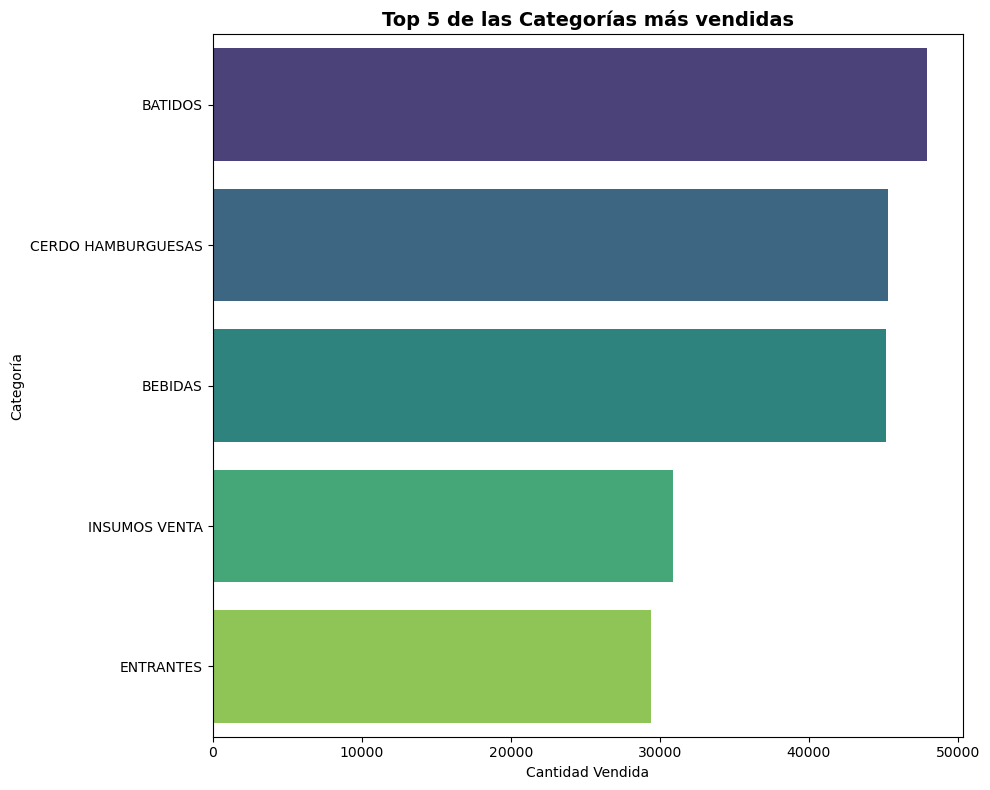

In [20]:
df_top_category = df_update.groupby('grupo_mercancia', as_index=False).agg({'cantidad':'sum'}).sort_values(by='cantidad', ascending=False).head(5)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_top_category, x='cantidad', y='grupo_mercancia', palette='viridis')
plt.title('Top 5 de las Categorías más vendidas', fontsize=14, fontweight='bold')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()


Resultado:
- La categoría **"BATIDOS"** lidera las ventas, lo cual confirma una alta demanda por productos fríos, refrescantes y de rápida salida. Esta información sugiere que este tipo de producto es un eje importante del negocio, tanto por volumen como por frecuencia de compra.
- Las categorías **"CERDO HAMBURGUESAS" y "BEBIDAS"*, que junto con los batidos configuran un patrón de consumo centrado en productos fáciles de preparar y consumir, típicos de un entorno informal o de atención rápida. Esto sugiere que el negocio responde bien a la demanda de comida tipo "consumo casual".
- Las categorías **"INSUMOS VENTA" y "ENTRANTES"** también presentan cifras relevantes. Aunque no lideran en volumen, forman parte de la oferta que complementa las opciones principales, por lo que su presencia es clave para mantener variedad y satisfacer a diferentes perfiles de clientes.
- El equilibrio entre categorías de alimentos principales (hamburguesas), complementos (entrantes) y bebidas (incluyendo batidos) indica que el negocio abarca todo el ciclo de una comida completa: desde refrescos hasta el plato fuerte y snacks.
- Este análisis revela que el modelo de negocio se sustenta sobre productos de alta rotación y bajo costo relativo, lo cual favorece la frecuencia de compra. Esta visión debe ser tenida en cuenta para futuras estrategias de abastecimiento, combos y promoción cruzada.

**3.4. Distribución de ventas según día de la semana.**

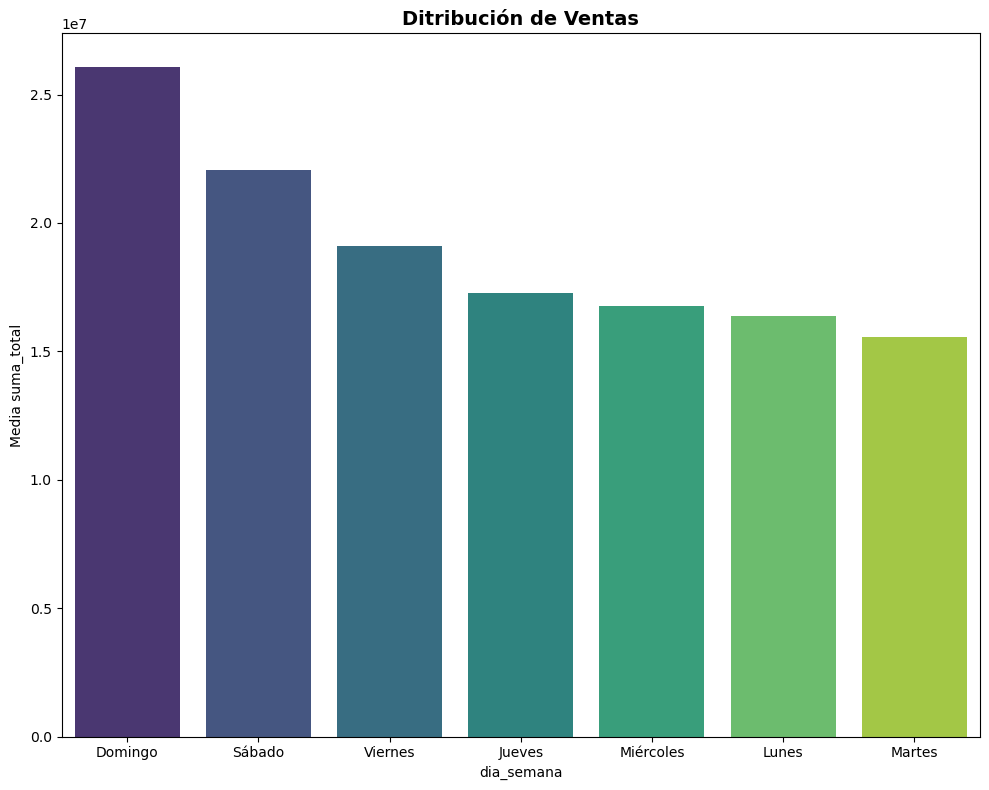

In [21]:
df_week_sales = df_update.groupby(['dia_semana'],as_index=False).agg({'suma_total':'sum'}).sort_values(by='suma_total',ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(data=df_week_sales, x='dia_semana', y='suma_total', palette='viridis')

plt.title('Ditribución de Ventas', fontsize=14, fontweight='bold')
plt.xlabel('dia_semana')
plt.ylabel('Media suma_total')
plt.tight_layout()
plt.show()

Resultados:
- Se observa que el domingo es el día de mayor volumen de ventas, superando claramente al resto de los días. Esto refleja una concentración significativa del consumo durante el fin de semana, posiblemente motivada por el ocio, reuniones sociales o descanso laboral.
- El sábado ocupa la segunda posición en ventas, seguido por el viernes, lo que refuerza el patrón de incremento progresivo de la actividad comercial desde el viernes hasta el domingo, días típicamente asociados a salidas y consumo fuera del hogar.
- Entre semana, los valores se mantienen más estables pero con tendencia decreciente. El martes representa el día de menor nivel de ventas, lo que puede deberse al bajo flujo de clientes durante inicios de semana, cuando se retoman las actividades laborales.
- Estos resultados sugieren una clara estacionalidad semanal en las ventas, donde los fines de semana son los puntos críticos de mayor rendimiento económico.

**3.5. Elasticidad de la Demanda.**

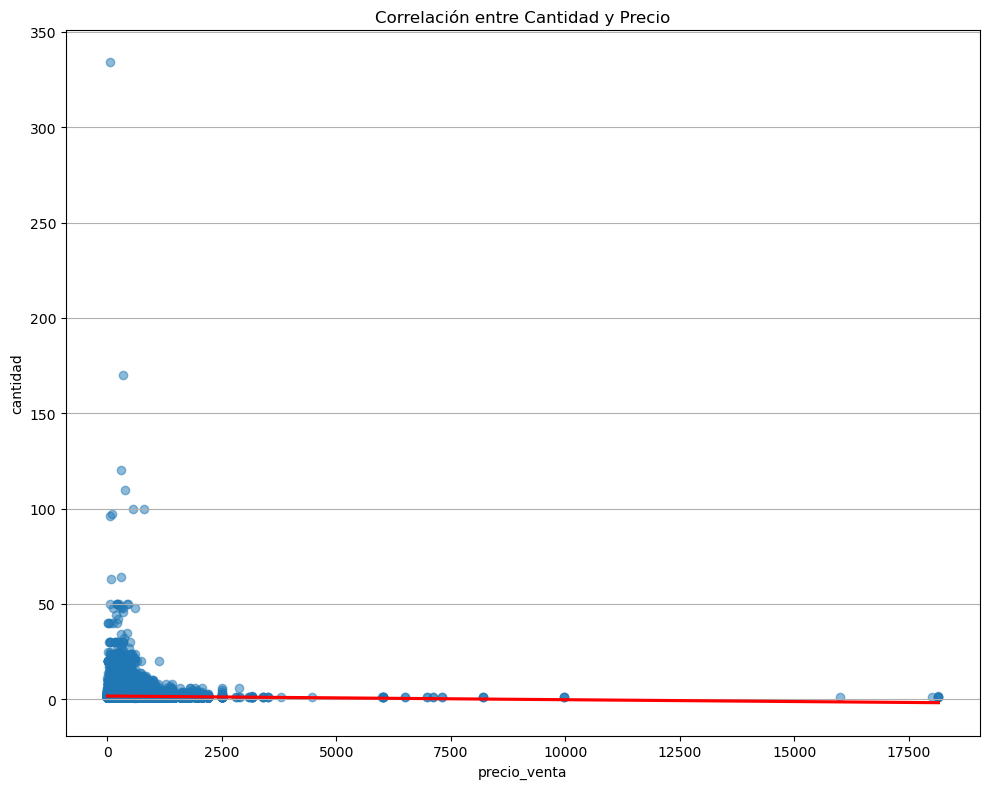

In [22]:
plt.figure(figsize=(10, 8))
sns.regplot(data=df_update, x='precio_venta', y='cantidad', scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Correlación entre Cantidad y Precio')
plt.xlabel('precio_venta')
plt.ylabel('cantidad')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Resultados:
- El análisis muestra una relación negativa y no lineal entre el precio de venta y la cantidad vendida. A medida que el precio aumenta, la cantidad vendida tiende a disminuir bruscamente, especialmente en los rangos de precios más altos.
- La mayor concentración de puntos se observa en la zona de precios bajos (menores a 2000 unidades monetarias), donde también se registran las mayores cantidades vendidas. Esto indica que los productos económicos tienen una rotación más alta, lo que es característico de artículos de consumo masivo o accesibles al público general.
- Se puede evidenciar que los productos con precios más elevados presentan una cantidad vendida significativamente menor, lo que puede estar asociado a productos de tipo premium o exclusivos, destinados a un segmento más reducido del mercado.
- La línea de tendencia (en rojo) evidencia visualmente esta correlación negativa, aunque la dispersión de los datos y la presencia de valores atípicos sugiere que la relación no es estrictamente lineal, y que podrían intervenir otros factores como tipo de producto, categoría o contexto de la venta.
- El análisis confirma lo observado en la matriz de correlación, donde el coeficiente entre precio_venta y cantidad fue ligeramente negativo (-0.036), aunque no lo suficientemente fuerte. 
- Como resumen, puede indicarse de manera rápida que los clientes que acuden al lugar podrían ser sensibles al precio, aunque queda analizar otros parametros que quizás inciden en los resultados.


**3.5. Relación de Ingresos y Cantidad por Mercancia.**

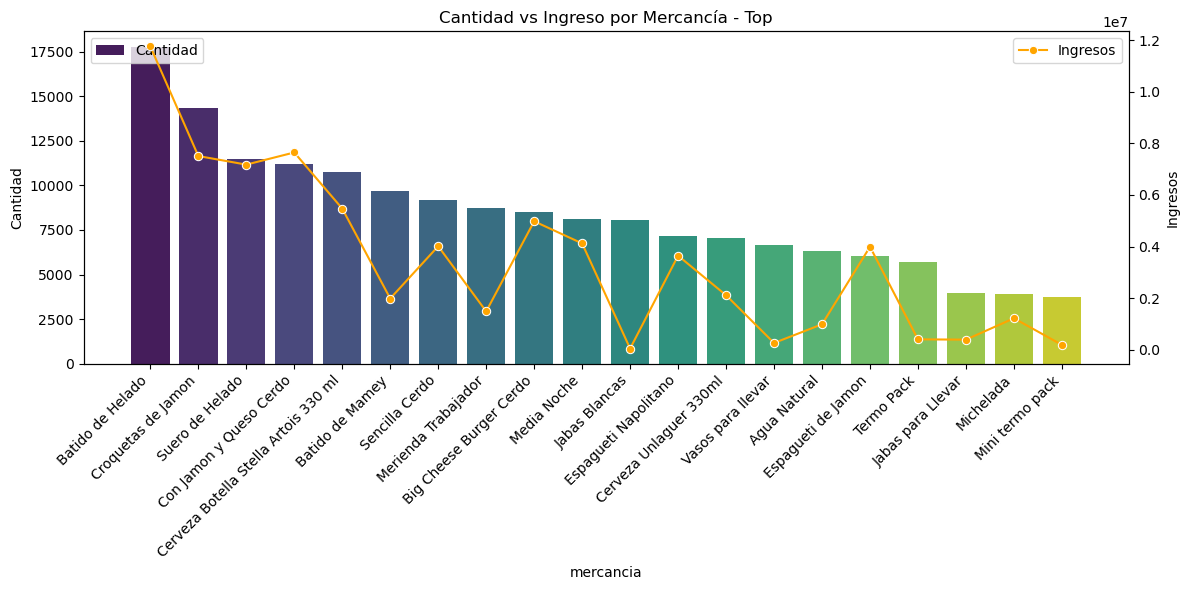

In [23]:
# Agrupamos por 'mercancia' y calculamos ambas métricas
df_agg = df_update.groupby('mercancia', as_index=False).agg({
    'cantidad': 'sum',
    'suma_total': 'sum'
})

top = df_agg.sort_values(by='cantidad', ascending=False).head(20)

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=top, x='mercancia', y='cantidad', ax=ax1, palette='viridis', label='Cantidad')
ax1.set_ylabel('Cantidad')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

ax2 = ax1.twinx()
sns.lineplot(data=top, x='mercancia', y='suma_total', ax=ax2, color='orange', marker='o', label='Ingresos')
ax2.set_ylabel('Ingresos')

plt.title('Cantidad vs Ingreso por Mercancía - Top')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Resultado:
- El **"Batido de Helado"** destaca como el producto más vendido en cantidad, y también como uno de los que más ingresos aporta, consolidándose como un producto clave tanto en volumen como en rentabilidad.
- Otros productos como **"Croquetas de Jamón", "Suero de Helado" y "Cerveza Botella Stella Artois 330 ml"** muestran también un buen equilibrio entre cantidad vendida e ingresos generados, siendo productos de rotación alta y buena rentabilidad relativa.
- En cambio **"Espargueti de Jamón"** presenta bajos volúmenes de venta pero genera ingresos significativos por unidad, lo que sugiere que es un productos de alto valor unitario, posiblemente dirigido a nichos específicos o utilizados como artículos de valor agregado.
- La inclusión de productos como ** Jabas Blancas, Vasos para llevar, Termo Pack, Mini termo pack** entre los 20 productos más vendidos, demuestra la preferencia de los clientes de llevar comida a casa, lo que pudiera dar pie a futuros análisis para potenciar estrategias de marketing.
- Se evidencia una diferencia importante entre los productos que apoyan el flujo constante de caja (alta cantidad) y aquellos que, aunque tienen menor rotación, pueden contribuir notablemente a los ingresos totales debido a su precio elevado.
- Esta visualización permite identificar oportunidades comerciales desde dos enfoques:
  - Productos de alta rotación: clave para mantener volumen constante y atraer tráfico.
  - Productos de alto valor: importantes para maximizar el ticket promedio y margen de ganancia.



#### **4. Análisis Exploratorio de la Serie de Tiempo.**

**4.1. Análisis general de la demanda total.**

In [24]:
df_st = df_update[["fecha", "cantidad", "es_festivo", "es_fin_semana"]].copy()
df_st.set_index("fecha", inplace=True)

# Agrupando por días. 
# df_st = df_st.resample('D').sum()// Variante pendiente a revisar.

df_st = df_update.groupby(df_update['fecha'].dt.floor('D')).agg({
    'cantidad': 'sum',
    'es_festivo': 'max',
    'es_fin_semana': 'max',      
})
df_st

#NOTA: Se usa resampling para completar los días que pudieran estar faltando y no existan saltos.

,cantidad,es_festivo,es_fin_semana
fecha,,,
2023-07-04,320.0,0,0
2023-07-05,406.0,0,0
2023-07-06,377.0,0,0
2023-07-07,467.0,0,0
2023-07-08,675.0,0,1
...,...,...,...
2025-02-24,335.0,0,0
2025-02-25,455.0,0,0
2025-02-26,501.0,0,0


In [25]:
# Suavisando con Media Móvil en un período semanal.
df_semanal = df_st['cantidad'].rolling(window=7).mean()
nivel_suavizado = df_st['cantidad'].rolling(window=7, center=True).mean()
media_general = df_st['cantidad'].mean()

fig = px.line(df_st, x=df_st.index, y='cantidad', title='Ventas Diarias con Suavizado Semanal',  labels={'cantidad': 'Ventas Diarias'})
fig.add_scatter(x=df_st.index, y=nivel_suavizado, mode='lines', name='Suavizado (7 días)', line=dict(color='red'))
fig.add_trace(go.Scatter(x=[df_st.index.min(), df_st.index.max()], y=[media_general, media_general], mode='lines', name=f"Media general ({media_general:.2f})", line=dict(color='green', dash='dash')))
fig.show()

Resumen:
- La línea azul representa la serie original que muestra fluctuaciones diarias evidentes, con cierta estabilidad en la variabilidad hacia el final del período.
- La línea roja corresponde al suavizado con media móvil de 7 días, lo que permite observar más claramente el comportamiento de la serie sin el ruido diario. Gracias a esta línea, se pueden identificar ciclos más regulares y cambios de tendencia a lo largo del tiempo, como la caída de las ventas por debajo de la media en el período de septiembre octubre.
- Puede observarse una interrupción significativa, como un periodo de ventas mínimas y luego nulas en el período comprendido del 8 de enero al 25 de enero del 2024 aproximadamente, que coincide con el cierre del local por reparaciones, aspecto validado con los especialistas del negocio.
- La línea verde discontinua representa la media general de toda la serie. Esta línea sirve como referencia para comparar los distintos tramos de la serie:
    - De manera general es obsevable como las ventas se mantienen al rededor de la media, exceptuando algunos períodos en específicos.
    - Se observa que durante el último trimestre del 2023, hubo un descenso de las ventas por debajo de la media general, que no es un patrón repetitivo en igual período del 2024. Lo que pudiera estar relacionado a temas logísticos propios del negocio.
    - A partir de febrero de 2024, las ventas se recuperan gradualmente y se estabilizan alrededor de la media, con algunos repuntes hacia finales del año y principio del 2025.
- Este tipo de análisis permite identificar períodos de baja o alta actividad, que serán claves para el modelado posterior. También valida la existencia de estacionalidad semanal, ya que se notan fluctuaciones regulares a lo largo de cada mes.
- A simple vista, se nota un ligero crecimiento en la magnitud de los picos hacia el final de la serie.

Para el presente trabajo se ha decidido mantener la interrupción a partir de que no es un evento estacionario. Por lo que además no se completará utilziando técnicas de valores faltante, para no afectar el comportamiento sin ventas reales del negocio. Partiendo además que existen herramientas que pueden modelar este comportamiento. 

**4.2. Descomposición estacional de la serie y selección de método.**

_4.2.1. Método Aditivo._

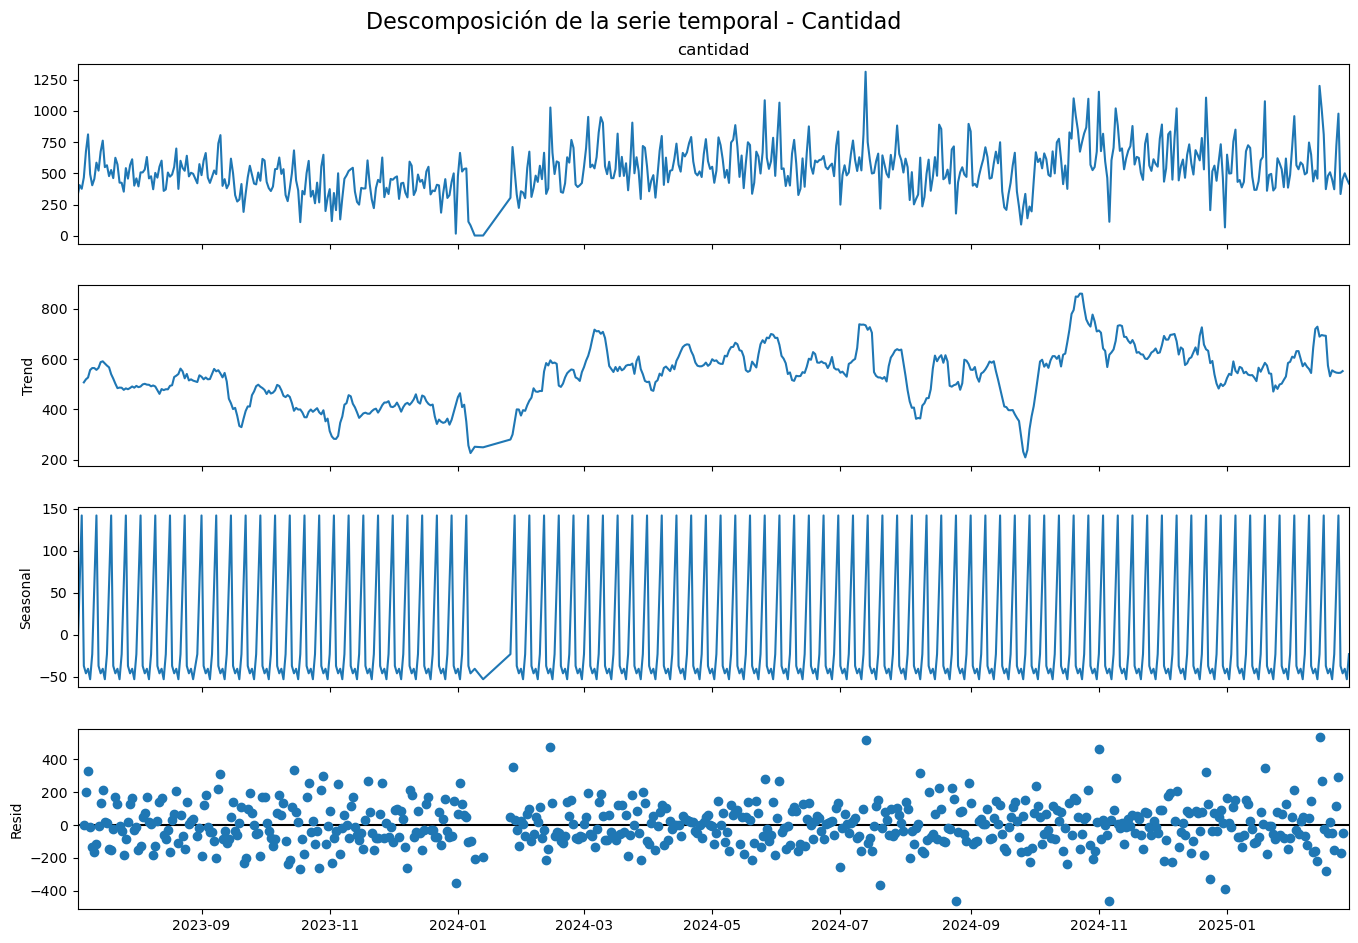

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposition = seasonal_decompose(df_st['cantidad'], model='additive', period=7)
fig = descomposition.plot()
fig.set_size_inches(15, 10)
plt.suptitle("Descomposición de la serie temporal - Cantidad", fontsize=16)
plt.show()

Resultado:

Tendencia:
- Muestra una tendencia ligeramente decreciente hasta finales de 2023.
- Se confirma la interrupción total en enero 2024, seguida de una recuperación progresiva.
- Desde mediados de 2024, la tendencia se mantiene relativamente estable, lo cual sugiere que el negocio ha alcanzado un nuevo punto de equilibrio-

Estacionalidad:
- El patrón estacional es regular y estable, con un comportamiento cíclico que se repite de forma constante a lo largo del tiempo.
- La amplitud se mantiene constante a lo largo del tiempo aunque durante el periodo de cierre (enero 2024), la estacionalidad también se ve interrumpida, como es esperable.
- Este patrón indica que las ventas tienden a repetirse semanalmente, reforzando la importancia de considerar los días de la semana en el modelado.

Residuo:
- Los residuos presentan una dispersión moderada alrededor de cero.
- Algunos picos extremos se observan durante el periodo de transición post-cierre.
- En general, no hay patrones visibles ni correlaciones aparentes, lo que indica una buena capacidad explicativa de los componentes principales.

_4.2.2. Método STL (Seasonal-Trend decomposition using Loess)._

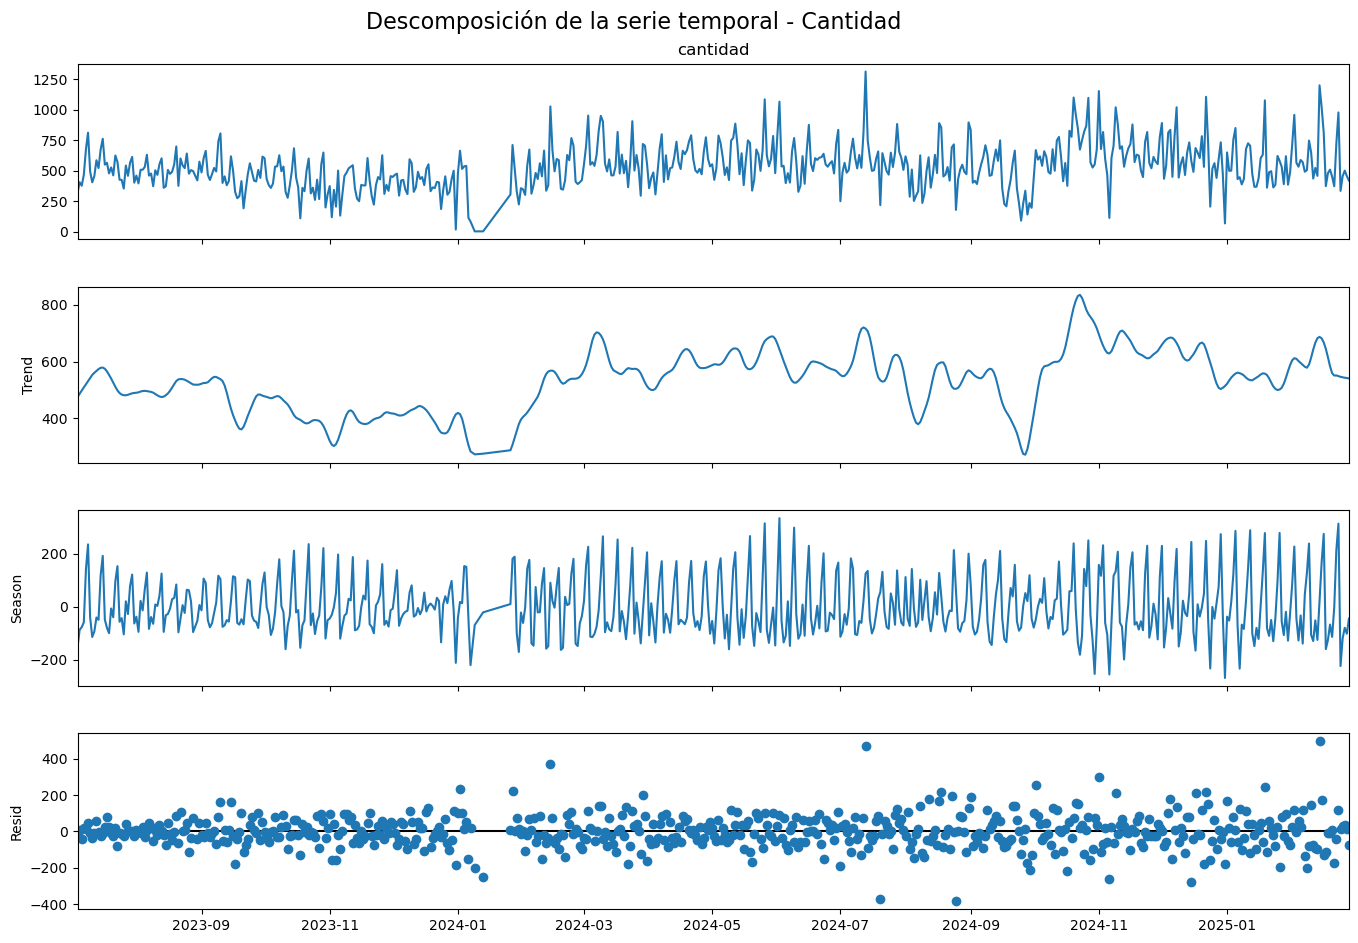

In [27]:
from statsmodels.tsa.seasonal import STL
 
descomposition_stl = STL(df_st['cantidad'], period=7).fit()

fig_stl = descomposition_stl.plot()
fig_stl.set_size_inches(15, 10)
plt.suptitle("Descomposición de la serie temporal - Cantidad", fontsize=16)
plt.show()

Resultado:

Tendencia:
- La tendencia decrece ligeramente hasta finales de 2023.
- El impacto del cierre se ve reflejado claramente con una caída total en enero 2024.
- A partir de marzo 2024, hay una recuperación sostenida, seguida de una meseta y nuevos picos hacia fines del año.
- La evolución de la tendencia indica que el negocio ha superado un periodo de interrupción y mantiene un ritmo saludable de ventas.

Estacionalidad:
- Se observa una estacionalidad no constante, donde la amplitud de los ciclos varía en el tiempo.
- Antes del cierre, la amplitud era menor, mientras que a partir de abril de 2024 se aprecia un incremento progresivo en las fluctuaciones estacionales.
- El patrón que puede evidenciarse es semana a semana, lo que valida una frecuencia estacional de 7 días.

Residuo:
- Los residuos están distribuidos alrededor de cero, sin presencia de patrones sistemáticos aparentes.
- La variabilidad es razonablemente estable, lo que indica que STL ha capturado adecuadamente los componentes sistemáticos.
- Existen algunos puntos dispersos que pueden corresponder a eventos excepcionales o promociones puntuales.

_4.2.3. Selección de método de Descomposición_:

In [28]:
print(f"Método Aditivo: VARIANZA => {descomposition.resid.var()}, MEDIA => {descomposition.resid.mean()}")
print(f"Método STL: VARIANZA => {descomposition_stl.resid.var()}, MEDIA => {descomposition_stl.resid.mean()}")

Método Aditivo: VARIANZA => 17051.124853448327, MEDIA => 0.505567459341772
Método STL: VARIANZA => 8257.22088131167, MEDIA => 0.08135309707418008


Resultado:

- Se selecciona el método STL como técnica de descomposición, debido a que sus residuos presentan menor varianza y una media más cercana a cero. Estos indicadores validan que el STL ajusta de manera más precisa la estructura de la serie, resultando más apropiado para su posterior modelado.

**4.3. Validación Estadística de la Descomposición STL**

**4.3.1. Análisis del Componente Tendencia. Prueba Mann-Kendall (Tendencia constante).**

_Hipótesis Nula(Ho): No hay cambios significativos en la Tendencia_

In [29]:
import pymannkendall as mk
resultado_trend = mk.original_test(descomposition_stl.trend.dropna())
resultado_trend


Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=12.165150631625368, Tau=0.3351697215388702, s=58040.0, var_s=22761708.666666668, slope=0.2814686851215491, intercept=461.84398637472214)

Resultado:
- El valor de h y p-value, confirman que la hipótesis nula puede ser rechazada, y por tanto, existe una tendencia real en la serie.
- El resultado de la prueba de Mann-Kendall aplicada sobre la componente de tendencia obtenida con el método de descomposición STL indica una tendencia creciente estadísticamente significativa en la serie, siendo respaldada por el parámetro trend='increasing'. Indicando que a lo largo del tiempo, las ventas tienden a incrementarse de forma sostenida.
- El estadístico Tau muestra una correlación positiva moderada entre el tiempo y los valores de la tendencia. Este valor refuerza la evidencia de una relación directa entre ambas variables.
- El valor z es elevado, lo que proporciona una fuerte evidencia contra la hipótesis nula, reforzando que la tendencia creciente no es producto del azar.
- La interceptación sugiere que el punto de partida estimado del nivel de ventas se sitúa alrededor de esa cifra.


**4.3.2.  Análisis del Componente Estacionalidad. Prueba Kruskal-Wallis (Estacionalidad significativa por grupos)**

_=> Hipótesis Nula(Ho): No hay estacionalidad significativa (No hay diferencias entre los días de la semana)._

In [30]:
from scipy.stats import kruskal

df_kruskal = df_st.copy()
df_kruskal['dia_semana'] = df_st.index.dayofweek 

grupos = [descomposition_stl.seasonal[df_kruskal['dia_semana'] == d].values for d in range(7)]

stat, p_kw = kruskal(*grupos)
print(f"Kruskal-Wallis p-value: {p_kw}")

Kruskal-Wallis p-value: 7.589803569317194e-75


Resultado:

- Se ha aplicado la prueba no paramétrica de Kruskal-Wallis a la componente estacional extraída mediante la descomposición STL, agrupando los datos por día de la semana (0 = lunes, ..., 6 = domingo).
- El resultado arrojó un p-value extremadamente bajo (7.589803569317194e-75), lo que indica que hay diferencias estadísticamente significativas entre los distintos días de la semana en cuanto al comportamiento estacional de las ventas, por lo que se rechaza la Hipótesis Nula.
- Esto implica que la estacionalidad semanal está presente de forma clara y consistente. La forma en que fluctúan las ventas a lo largo de los días de la semana no es aleatoria, y hay patrones diferenciados que deben ser tenidos en cuenta.

**4.3.3. Análisis del Componente Residuos. Ljung-Box (Autocorrelación de residuos)**

_=> Hipótesis Nula(Ho): No existe autocorrelación entre los residuos. (Los residuos son ruido blanco)_

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Se utilizan retardos de una semana y multiplos de 7.
ljungbox = acorr_ljungbox(descomposition_stl.resid.dropna(), lags=[7, 14, 21, 28], return_df=True)
print(ljungbox)

       lb_stat     lb_pvalue
7   156.425947  1.811682e-30
14  187.406010  2.027211e-32
21  195.930922  2.284456e-30
28  203.765238  1.326015e-28


Resultado:

- Los valores obtenidos están muy por debajo del umbral habitual de significancia (0.05), por lo que se rechaza la Hipótesis Nula y por tanto los residuos No son ruido blanco.
- Los residuos todavía contienen estructura temporal no explicada, lo cual puede deberse a:
    - Efectos no lineales o interacciones no capturadas por la descomposición STL.
    - Estacionalidades más complejas o cambios en la varianza que no han sido descompuestos adecuadamente.



**4.3. Análisis de Autocorrelaciones**

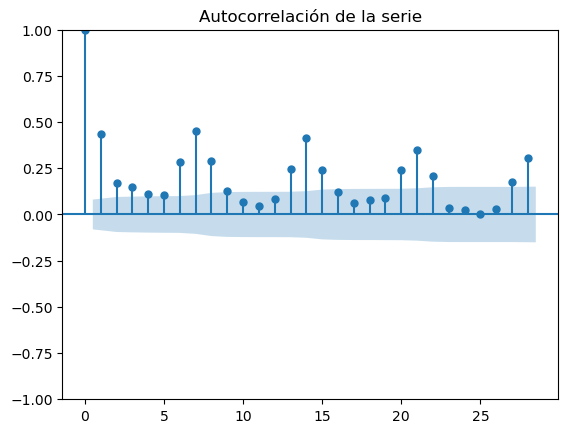

In [32]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_st['cantidad'].dropna(), lags=28)
plt.title('Autocorrelación de la serie')
plt.show()

Resultados:
- Se observan valores de autocorrelación significativamente positivos en los primeros lags (especialmente hasta el lag 7), que se mantienen por encima del intervalo de confianza. Esto indica que las ventas actuales están correlacionadas con las de días anteriores cercanos, lo cual es un indicio claro de dependencia temporal.
- La serie muestra fuerte autocorrelación temporal, especialmente en los primeros días y en múltiplos semanales. Por lo que se puede concluir que no es aleatoria y tiene estructura autoregresiva.

**4.4. Prueba de Estacionariedad. Prueba de Dickey-Fuller Aumentada (Raíz unitaria)**

_=> Hipótesis Nula(Ho): No es estacionaria. (Tiene una raíz unitaria)_

In [33]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(df_st['cantidad'].dropna())  # importante eliminar NaNs

# Mostrar resultados
print('ADF Statistic:', resultado_adf[0])
print('p-value:', resultado_adf[1])
print('Valores críticos:')
for clave, valor in resultado_adf[4].items():
    print(f'   {clave}: {valor}')


ADF Statistic: -3.0709231950870466
p-value: 0.028781182653316917
Valores críticos:
   1%: -3.4417938762914972
   5%: -2.866588428280353
   10%: -2.5694586650317475


Resultados:
- El p-value = 0.0288 es menor a 0.05, por tanto, se rechaza la hipótesis nula al 95% de confianza.
- Estadísticamente, la serie puede considerarse estacionaria en nivel bajo los supuestos de la prueba ADF.

Conclusiones:

- A partir del análisis visual y las pruebas estadísticas aplicadas (Mann-Kendall, Kruskal-Wallis, Ljung-Box y ADF), se concluye que la serie presenta una tendencia ascendente y estacionalidad pronunciada con amplitud variable, lo cual rompe el supuesto de estacionariedad estricta.
- Aunque la prueba de Dickey-Fuller sugiere que no hay raíz unitaria por lo que la serie es estacionaria, los residuos tras la prueba de Ljon-Box indican que existe estructura temporal no explicada aún por la tendencia ni la estacionalidad.Esto sugiere que la serie no está completamente modelada y que se requiere un modelo que explique las correlaciones restantes.
- Por tanto, se concluye que la serie no es completamente estacionaria, pero no es necesario aplicar diferenciación, dado que pueden utilizarce modelos de predicción qué manejen explícitamente componentes de tendencia y estacionalidad.
- Esta decisión evita una transformación innecesaria de los datos y permitiría preservar la interpretabilidad del comportamiento real del negocio.


#### **5. Construcción del Modelo predictivo.**

Para modelar la demanda diaria del caso de uso, se analizarán modelos que sean capaces de capturar tanto la estructura temporal(Estacionalidad y Tendencia) como los factores externos, teniendo en cuenta los análisis anteriores.

Esta selección está diseñada sobre la base de:

- Dataframe con las variables: cantidad, es_festivo, es_fin_semana.
- El periodo de datos oscila ente julio 2023 y febrero 2025.
- Incorporación de la interrupción por cierre.
- El análisis de descomposición de la serie y las pruebas estadísticas realizadas ( Man-Kendall, Kruskal-Wallis, Ljung-Box, ADF, etc.).
- El EDA ya desarrollado.

In [34]:
df_st.head()

,cantidad,es_festivo,es_fin_semana
fecha,,,
2023-07-04,320.0,0,0
2023-07-05,406.0,0,0
2023-07-06,377.0,0,0
2023-07-07,467.0,0,0
2023-07-08,675.0,0,1


**5.1. Selección del Modelo.**

In [35]:
# Creando train y test.
df_train = df_st[df_st.index < '2025-01-01']
df_test = df_st[df_st.index >= '2025-01-01']

# Obtención de las variables exógenas
exog_train = df_train[['es_festivo']]
exog_test = df_test[['es_festivo']]


**5.1.1. Modelo STL+SARIMAX**

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Descomposición STL sobre el set de entrenamiento. 
# A partir de los resultados del análisis que demuestran una etacionadlidad semanal se selecciona un período de 7 días.
stl = STL(df_train['cantidad'], period=7)
stl_result = stl.fit()

# Extraer componentes de la Serie
trend = stl_result.trend
seasonal = stl_result.seasonal
resid = stl_result.resid

# Alinear residuos y variables exógenas
resid_model = resid.dropna()
exog_model = exog_train.loc[resid_model.index]




In [37]:
# Crea el modelo SARIMAX sobre los residuos.
model_stl_smx = SARIMAX(resid_model, exog=exog_model, order=(3, 0, 3), enforce_stationarity=False)
model_stl_sarimax = model_stl_smx.fit(disp=False)

n_test = len(exog_test)
forecast_resid = model_stl_sarimax.forecast(steps=n_test, exog=exog_test)

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [38]:
trend_forecast = np.repeat(trend.iloc[-1], n_test)
# Estacionalidad: repite el patrón semanal sobre el periodo de test
seasonal_pattern = seasonal[-7:].values  # último patrón semanal
seasonal_test = np.tile(seasonal_pattern, int(np.ceil(n_test / 7)))[:n_test]

# Reconstruye la serie predicha
forecast_stl_sarimax = trend_forecast + seasonal_test + forecast_resid.values
forecast_stl_sarimax = pd.Series(forecast_stl_sarimax, index=df_test.index, name='predicho')

In [39]:

actual = df_test['cantidad']
rmse_stl_smx = np.sqrt(mean_squared_error(actual, forecast_stl_sarimax))
mae_stl_smx = mean_absolute_error(actual, forecast_stl_sarimax)
mape_stl_smx = np.mean(np.abs((actual - forecast_stl_sarimax) / actual)) * 100
r2_stl_sarimax = r2_score(actual, forecast_stl_sarimax)
print(f"STL+SARIMAX: RMSE: {rmse_stl_smx:.2f}, MAE: {mae_stl_smx:.2f}, MAPE: {mape_stl_smx}, R2: {r2_stl_sarimax: .4f}, RMSE Relative: { rmse_stl_smx/np.mean(forecast_stl_sarimax) }")


STL+SARIMAX: RMSE: 253.71, MAE: 197.26, MAPE: 33.87985426276433, R2: -0.7532, RMSE Relative: 0.6499861081413913


**5.1.2. SARIMAX**

In [40]:
model_smx = SARIMAX(
    df_train['cantidad'],
    exog=exog_train,
    order=(3,0,3),
    seasonal_order=(1,0,1,7),
    enforce_stationarity=False
)
fit_smx = model_smx.fit(disp=False)

# Predicción para el periodo de test
forecast_smx = fit_smx.forecast(steps=len(df_test), exog=exog_test)

# Alinear las predicciones al índice de fechas del test
forecast_smx = pd.Series(forecast_smx.values, index=df_test.index, name='predicho')

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [41]:
actual_smx = df_test['cantidad']

rmse_smx = np.sqrt(mean_squared_error(actual_smx, forecast_smx))
mae_smx = mean_absolute_error(actual_smx, forecast_smx)
mape_smx = np.mean(np.abs((actual_smx - forecast_smx) / actual_smx)) * 100
r2_sarimax = r2_score(actual_smx, forecast_smx)
print(f"SARIMAX Directo: RMSE: {rmse_smx:.2f}, MAE: {mae_smx:.2f}, MAPE: {mape_smx:.2f}, R2:{r2_sarimax:.4f}, RMSE Relative: { rmse_smx/np.mean(forecast_smx) }")


SARIMAX Directo: RMSE: 184.35, MAE: 139.92, MAPE: 23.58, R2:0.0744, RMSE Relative: 0.3892215724339275


**5.1.3. PROPHET**

In [42]:
from prophet import Prophet

# Se ajusta el train/set debido a que requiere que las columnas sean [ds,y]
train_prophet = df_train.reset_index().rename(columns={'fecha':'ds', 'cantidad':'y'})
test_prophet = df_test.reset_index().rename(columns={'fecha':'ds', 'cantidad':'y'})

In [43]:
# Crear modelo con estacionalidad diaria
model_prophet = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False)

# Agregar variables exógenas como regresores
model_prophet.add_regressor('es_festivo')
model_prophet.add_regressor('es_fin_semana')

model_prophet.fit(train_prophet)

02:41:18 - cmdstanpy - INFO - Chain [1] start processing
02:41:18 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
future = test_prophet[['ds', 'es_festivo', 'es_fin_semana']]
forecast = model_prophet.predict(future)

In [45]:
actual_prophet = df_test['cantidad'].values
forecast_prophet = forecast['yhat'].values

rmse_prophet = np.sqrt(mean_squared_error(actual_prophet, forecast_prophet))
mae_prophet = mean_absolute_error(actual_prophet, forecast_prophet)
mape_prophet = np.mean(np.abs((actual_prophet - forecast_prophet) / actual_prophet)) * 100
r2_prophet = r2_score(actual_prophet, forecast_prophet)
print(f"PROPHET: RMSE: {rmse_prophet:.2f}, MAE: {mae_prophet:.2f}, MAPE: {mape_prophet:.2f}, R2: {r2_prophet:.4f}, RMSE Relative: { rmse_prophet/np.mean(forecast_prophet) }")


PROPHET: RMSE: 160.92, MAE: 128.22, MAPE: 25.67, R2: 0.2947, RMSE Relative: 0.25364211979575924


**5.1.4. AutoARIMA**

In [46]:
import pmdarima as pm

y_train = df_train['cantidad']
y_test  = df_test['cantidad']

model_autoarima = pm.auto_arima(
    y=y_train,
    exogenous=exog_train,
    start_p=1, start_q=1, max_p=3, max_q=3,
    seasonal=True,
    m=7,  # Periodo de estacionalidad semanal
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    d=None, D=None,  # Deja que autoarima determine si diferencia o no
    trace=True,  
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=6878.626, Time=1.64 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=7061.404, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=6957.265, Time=1.46 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=6884.647, Time=2.53 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=7059.409, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=3.05 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=6840.012, Time=3.59 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=6773.628, Time=6.92 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=17.91 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=6776.826, Time=20.07 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=6811.053, Time=14.48 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=4.94 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=14.60 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=6798.597, Time=8.27 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=6894.18

In [47]:
forecast_autoarima = model_autoarima.predict(n_periods=len(y_test), exogenous=exog_test)

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [48]:
# Permite asegurar que no existan nulos en test
mask = ~np.isnan(y_test.values)
rmse_autoarima = np.sqrt(mean_squared_error(y_test.values[mask], forecast_autoarima[mask]))
mae_autoarima = mean_absolute_error(y_test.values[mask], forecast_autoarima[mask])
mape_autoarima = np.mean(np.abs((y_test.values[mask] - forecast_autoarima[mask]) / y_test.values[mask])) * 100
r2_autoarima = r2_score(y_test.values[mask], forecast_autoarima[mask])
rmse_rel_autoarima = rmse_autoarima / np.mean(forecast_autoarima[mask])

print(f"AUTOARIMA: RMSE: {rmse_autoarima:.2f}, MAE: {mae_autoarima:.2f}, MAPE: {mape_autoarima:.2f}, R2: {r2_autoarima:.4f}, RMSE Relative: {rmse_rel_autoarima:.2f}")


AUTOARIMA: RMSE: 162.46, MAE: 113.70, MAPE: 18.71, R2: 0.2812, RMSE Relative: 0.31


**Resultado**

- _STL+SARIMAX y SARIMAX Directo_:
Ambos modelos tradicionales presentan métricas significativamente peores en comparación con Prophet y AutoARIMA, especialmente en términos de MAPE (mayor error porcentual) y R2 (valores negativos, indicando que el modelo es peor que predecir la media). Esto sugiere que no están capturando de forma eficiente la dinámica temporal ni la estacionalidad del negocio.

- _PROPHET_:
Como es observable se muestra una clara mejora en todas las métricas frente a los modelos ARIMA/SARIMAX. El MAPE (25.67%) y el RMSE Relative (0.25) son considerablemente más bajos, lo que indica mejor capacidad predictiva y estabilidad. Además, el R2 positivo (0.29) sugiere que el modelo explica una proporción razonable de la varianza observada. Permite además incorporar fácilmente variables exógenas (festivos, fines de semana), lo que se alinea con la estructura del negocio.

- _AUTOARIMA_:
 Que selecciona automáticamente los hiperparámetros, obtiene el MAPE más bajo (18.71%) y un RMSE casi igual al de Prophet, pero su R2 es ligeramente inferior (0.28 vs. 0.29). Esto indica que, aunque es preciso en promedio, puede no capturar tan bien ciertas fluctuaciones y variabilidad estructural de la serie, sobre todo si hay efectos exógenos o no linealidades.

**Recomendación final:**

El modelo **Prophet** es el modelo recomendado para el pronóstico de la demanda a partir de los análisis realizados:
- Consigue un balance óptimo entre precisión (RMSE, MAE) y robustez (R2 positivo).
- Permite una integración sencilla y eficaz de variables exógenas clave para el negocio (festivos, fines de semana), lo que puede ser decisivo en escenarios reales.
- Muestra un rendimiento estable y consistente a lo largo de todo el periodo, lo cual se ha comprobado en las comparaciones de las métricas obtenidas.
- Ofrece interpretabilidad y facilidad de ajuste de hiperparámetros para lograr mejoras adicionales.
- Aunque AutoARIMA es competitivo y con un MAPE muy bajo, no supera a Prophet en la capacidad de capturar la variabilidad estructural ni en integración de regresores externos.

**5.2. Ajuste de Hiperparámetros y Afinamiento del modelo.**

**5.2.1. Ajuste de Hiperparámetro.**

In [49]:
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.2, 0.5], # Controla la flexibilidad del modelo para capturar cambios bruscos en la tendencia.
    'seasonality_prior_scale': [1.0, 5.0, 10.0], # Controla la flexibilidad para ajustar los patrones estacionales.
    'holidays_prior_scale': [1.0, 10.0, 20.0], # Controla cuánto permite el modelo ajustar el efecto de los festivos. 
    'seasonality_mode': ['additive', 'multiplicative']
}

# Genera todas las combinaciones
results = []
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

for params in all_params:
    model = Prophet(
        weekly_seasonality=True,
        daily_seasonality=False,
        yearly_seasonality=False,
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
    )
    model.add_regressor('es_festivo')
    model.add_regressor('es_fin_semana')
    model.fit(train_prophet)
    
    # Predicciones en train
    future_train = train_prophet[['ds', 'es_festivo', 'es_fin_semana']]
    forecast_train = model.predict(future_train)
    actual_train = train_prophet['y'].values
    pred_train = forecast_train['yhat'].values
    
    rmse_train = np.sqrt(mean_squared_error(actual_train, pred_train))
    mae_train = mean_absolute_error(actual_train, pred_train)
    mape_train = np.mean(np.abs((actual_train - pred_train) / actual_train)) * 100
    r2_train = r2_score(actual_train, pred_train)
    
    # Predicciones en test
    future_test = test_prophet[['ds', 'es_festivo', 'es_fin_semana']]
    forecast_test = model.predict(future_test)
    actual_test = test_prophet['y'].values
    pred_test = forecast_test['yhat'].values
    
    rmse_test = np.sqrt(mean_squared_error(actual_test, pred_test))
    mae_test = mean_absolute_error(actual_test, pred_test)
    mape_test = np.mean(np.abs((actual_test - pred_test) / actual_test)) * 100
    r2_test = r2_score(actual_test, pred_test)
    
    results.append({
                'changepoint_prior_scale': params['changepoint_prior_scale'],
                'seasonality_mode': params['seasonality_mode'],
                'holidays_prior_scale': params['holidays_prior_scale'],
                'rmse_train': rmse_train,
                'mae_train': mae_train,
                'mape_train': mape_train,
                'r2_train': r2_train,
                'rmse_test': rmse_test,
                'mae_test': mae_test,
                'mape_test': mape_test,
                'r2_test': r2_test
            })

02:44:53 - cmdstanpy - INFO - Chain [1] start processing
02:44:53 - cmdstanpy - INFO - Chain [1] done processing
02:44:55 - cmdstanpy - INFO - Chain [1] start processing
02:44:55 - cmdstanpy - INFO - Chain [1] done processing
02:44:57 - cmdstanpy - INFO - Chain [1] start processing
02:44:58 - cmdstanpy - INFO - Chain [1] done processing
02:44:59 - cmdstanpy - INFO - Chain [1] start processing
02:45:00 - cmdstanpy - INFO - Chain [1] done processing
02:45:01 - cmdstanpy - INFO - Chain [1] start processing
02:45:02 - cmdstanpy - INFO - Chain [1] done processing
02:45:04 - cmdstanpy - INFO - Chain [1] start processing
02:45:04 - cmdstanpy - INFO - Chain [1] done processing
02:45:06 - cmdstanpy - INFO - Chain [1] start processing
02:45:06 - cmdstanpy - INFO - Chain [1] done processing
02:45:08 - cmdstanpy - INFO - Chain [1] start processing
02:45:08 - cmdstanpy - INFO - Chain [1] done processing
02:45:09 - cmdstanpy - INFO - Chain [1] start processing
02:45:09 - cmdstanpy - INFO - Chain [1]

In [50]:
df_results = pd.DataFrame(results)
best_row = df_results.sort_values('rmse_test').iloc[0]
print("\nMejor configuración:", best_row)

# Construir modelo con mejores hiperparámetros
m_cv = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False,
    changepoint_prior_scale=best_row['changepoint_prior_scale'],
    seasonality_prior_scale=5.0,
    holidays_prior_scale=best_row['holidays_prior_scale'],
    seasonality_mode=best_row['seasonality_mode']
)
m_cv.add_regressor('es_festivo')
m_cv.add_regressor('es_fin_semana')
m_cv.fit(train_prophet)

df_cv = cross_validation(
    m_cv,
    initial='365 days',   # Usa un año para entrenar antes del primer corte
    period='30 days',     # Cada 30 días hace un nuevo split
    horizon='60 days',    # Evalúa el rendimiento a 60 días en el futuro
    parallel="processes"
)
df_pfm = performance_metrics(df_cv)
print(df_pfm[['horizon', 'mae', 'rmse', 'mape', 'coverage']].head())



Mejor configuración: changepoint_prior_scale              0.05
seasonality_mode           multiplicative
holidays_prior_scale                 10.0
rmse_train                     147.600597
mae_train                      104.450016
mape_train                      88.592162
r2_train                         0.358136
rmse_test                      152.336889
mae_test                       117.987817
mape_test                       23.274619
r2_test                          0.367934
Name: 21, dtype: object


02:46:11 - cmdstanpy - INFO - Chain [1] start processing
02:46:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon         mae        rmse      mape  coverage
0  6 days  117.635957  162.735137  0.381160  0.766667
1  7 days  123.437060  170.551562  0.406846  0.766667
2  8 days  136.507403  187.080207  0.395305  0.666667
3  9 days  149.779908  210.826214  0.385153  0.666667
4 10 days  160.588334  215.267874  0.394475  0.633333


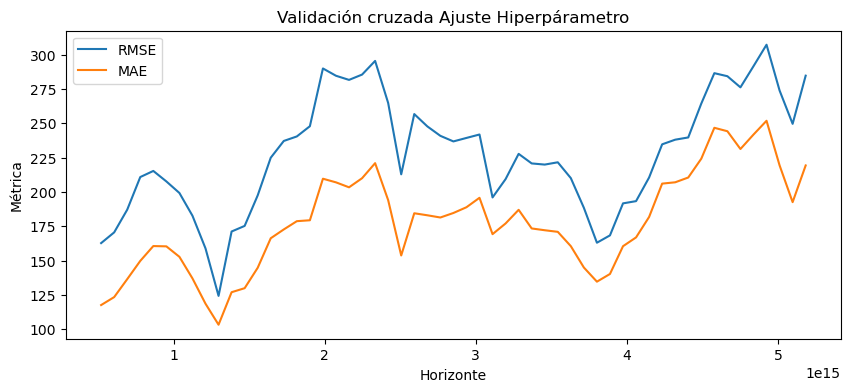

In [51]:
plt.figure(figsize=(10, 4))
plt.plot(df_pfm['horizon'], df_pfm['rmse'], label='RMSE')
plt.plot(df_pfm['horizon'], df_pfm['mae'], label='MAE')
# plt.plot(df_pfm['horizon'], df_pfm['mape'], label='MAPE')
plt.xlabel('Horizonte')
plt.ylabel('Métrica')
plt.title('Validación cruzada Ajuste Hiperpárametro')
plt.legend()
plt.show()

Resultados:

- Se observa cierta variabilidad y picos en las métricas RMSE y MAE en distintos horizontes. MAPE es bajo y estable.
- Hay momentos de mayor error (picos), indicando periodos donde el modelo pierde precisión temporal.

**5.2.2. Fine Tunin.**

In [52]:
param_grid_tf = {  
    'changepoint_prior_scale': [0.005,  0.02, 0.03, 0.05,  0.1, 0.15],
    'seasonality_prior_scale': [2.0,  5.0, 7.0, 10.0],
    'holidays_prior_scale': [5.0, 7.5, 10.0,  15.0],
    'seasonality_mode': ['additive', 'multiplicative']
}


# Genera todas las combinaciones
all_params_tf = [dict(zip(param_grid_tf.keys(), v)) for v in itertools.product(*param_grid_tf.values())]
results_tf = []

for params in all_params_tf:
    model = Prophet(
        weekly_seasonality=True,
        daily_seasonality=False,
        yearly_seasonality=False,
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
    )
    model.add_regressor('es_festivo')
    model.add_regressor('es_fin_semana')
    model.fit(train_prophet)
    
    # --- Predicciones en train ---
    future_train = train_prophet[['ds', 'es_festivo', 'es_fin_semana']]
    forecast_train = model.predict(future_train)
    actual_train = train_prophet['y'].values
    pred_train = forecast_train['yhat'].values
    
    rmse_train = np.sqrt(mean_squared_error(actual_train, pred_train))
    mae_train = mean_absolute_error(actual_train, pred_train)
    mape_train = np.mean(np.abs((actual_train - pred_train) / actual_train)) * 100
    r2_train = r2_score(actual_train, pred_train)
    
    # --- Predicciones en test ---
    future_test = test_prophet[['ds', 'es_festivo', 'es_fin_semana']]
    forecast_test = model.predict(future_test)
    actual_test = test_prophet['y'].values
    pred_test = forecast_test['yhat'].values
    
    rmse_test = np.sqrt(mean_squared_error(actual_test, pred_test))
    mae_test = mean_absolute_error(actual_test, pred_test)
    mape_test = np.mean(np.abs((actual_test - pred_test) / actual_test)) * 100
    r2_test = r2_score(actual_test, pred_test)
    
    results_tf.append({
                'changepoint_prior_scale': params['changepoint_prior_scale'],
                'seasonality_mode': params['seasonality_mode'],
                'holidays_prior_scale': params['holidays_prior_scale'],
                'rmse_train': rmse_train,
                'mae_train': mae_train,
                'mape_train': mape_train,
                'r2_train': r2_train,
                'rmse_test': rmse_test,
                'mae_test': mae_test,
                'mape_test': mape_test,
                'r2_test': r2_test
            })

02:46:30 - cmdstanpy - INFO - Chain [1] start processing
02:46:30 - cmdstanpy - INFO - Chain [1] done processing
02:46:31 - cmdstanpy - INFO - Chain [1] start processing
02:46:31 - cmdstanpy - INFO - Chain [1] done processing
02:46:33 - cmdstanpy - INFO - Chain [1] start processing
02:46:33 - cmdstanpy - INFO - Chain [1] done processing
02:46:35 - cmdstanpy - INFO - Chain [1] start processing
02:46:35 - cmdstanpy - INFO - Chain [1] done processing
02:46:36 - cmdstanpy - INFO - Chain [1] start processing
02:46:37 - cmdstanpy - INFO - Chain [1] done processing
02:46:38 - cmdstanpy - INFO - Chain [1] start processing
02:46:39 - cmdstanpy - INFO - Chain [1] done processing
02:46:40 - cmdstanpy - INFO - Chain [1] start processing
02:46:40 - cmdstanpy - INFO - Chain [1] done processing
02:46:42 - cmdstanpy - INFO - Chain [1] start processing
02:46:42 - cmdstanpy - INFO - Chain [1] done processing
02:46:43 - cmdstanpy - INFO - Chain [1] start processing
02:46:43 - cmdstanpy - INFO - Chain [1]

In [53]:
df_results_tf = pd.DataFrame(results_tf)
best_row_tunin = df_results_tf.sort_values('rmse_test').iloc[0]
print("\nMejor configuración:\n", best_row_tunin)

# Construir modelo con mejores hiperparámetros
model_prophet_cv = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False,
    changepoint_prior_scale=best_row_tunin['changepoint_prior_scale'],
    seasonality_prior_scale=5.0,
    holidays_prior_scale=best_row_tunin['holidays_prior_scale'],
    seasonality_mode=best_row_tunin['seasonality_mode']
)
model_prophet_cv.add_regressor('es_festivo')
model_prophet_cv.add_regressor('es_fin_semana')
model_prophet_cv.fit(train_prophet)

df_cv_tf = cross_validation(
    model_prophet_cv,
    initial='365 days',   # Usa un año para entrenar antes del primer corte
    period='30 days',     # Cada 30 días hace un nuevo split
    horizon='60 days',    # Evalúa el rendimiento a 60 días en el futuro
    parallel="processes"
)
df_pfm_ft = performance_metrics(df_cv_tf)
print(df_pfm_ft[['horizon', 'mae', 'rmse', 'mape', 'coverage']].head())



Mejor configuración:
 changepoint_prior_scale             0.005
seasonality_mode           multiplicative
holidays_prior_scale                 10.0
rmse_train                     154.654897
mae_train                      111.621031
mape_train                      98.001231
r2_train                         0.295317
rmse_test                      149.268456
mae_test                       113.737903
mape_test                       22.158989
r2_test                          0.393141
Name: 5, dtype: object


02:49:05 - cmdstanpy - INFO - Chain [1] start processing
02:49:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon         mae        rmse      mape  coverage
0  6 days  105.005823  146.580697  0.357210  0.800000
1  7 days  110.304662  155.159245  0.379415  0.800000
2  8 days  127.403194  171.613999  0.375490  0.733333
3  9 days  141.631284  202.000386  0.366452  0.733333
4 10 days  139.814211  200.736033  0.357854  0.766667


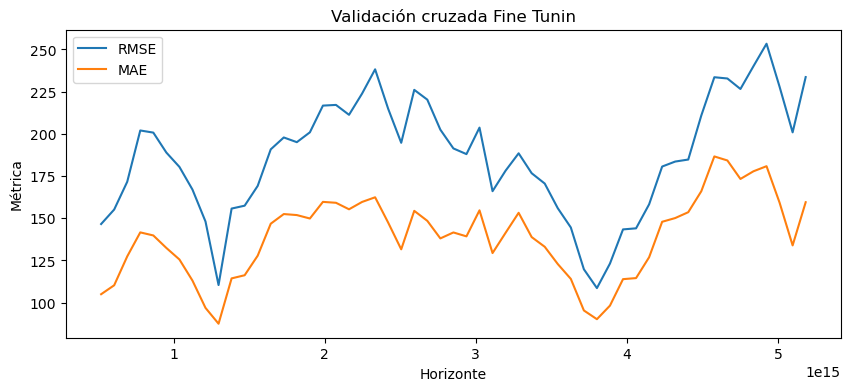

In [54]:
plt.figure(figsize=(10, 4))
plt.plot(df_pfm_ft['horizon'], df_pfm_ft['rmse'], label='RMSE')
plt.plot(df_pfm_ft['horizon'], df_pfm_ft['mae'], label='MAE')
# plt.plot(df_pfm['horizon'], df_pfm['mape'], label='MAPE')
plt.xlabel('Horizonte')
plt.ylabel('Métrica')
plt.title('Validación cruzada Fine Tunin')
plt.legend()
plt.show()

Debido a que el MAPE no se encuentra en la misma escala que el resto de los errores se realiza un análisis por separado entre los resultados obtenidos en el ajuste de hiperparámetros y el Fine-tunin.

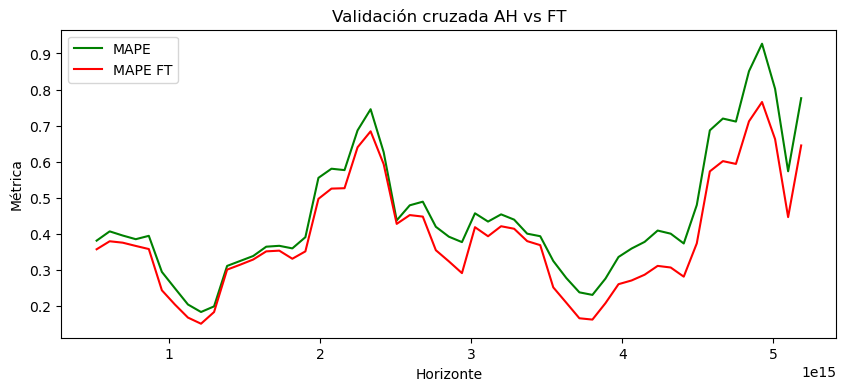

In [55]:
plt.figure(figsize=(10, 4))
plt.plot(df_pfm['horizon'], df_pfm['mape'], label='MAPE', color='green')
plt.plot(df_pfm_ft['horizon'], df_pfm_ft['mape'], label='MAPE FT', color='red')
plt.xlabel('Horizonte')
plt.ylabel('Métrica')
plt.title('Validación cruzada AH vs FT')
plt.legend()
plt.show()

Resultados:

- El MAPE, es también baja y estable, pero con valores absolutos más bajos.
- Reduce todos los errores principales (MAE, RMSE, MAPE) en todos los horizontes, especialmente en 7 días (MAE de 123.4 a 110.3, RMSE de 170.6 a 155.2, MAPE de 0.4068 a 0.3794).
- Muestra menos picos y menos dispersión en los errores, señal de mayor estabilidad y generalización.
- Tiene mayor incremento en el “coverage” lo que implica que los intervalos de confianza son más acertados, es decir, contienen con mayor probabilidad los valores reales futuros.
- Visualmente, las gráficas del modelo ajustado están más bajas y suaves, señal de menor error y menos varianza en los splits temporales.




Conclusión Final:
- El modelo Prophet ajustado es el mejor candidato para el pronóstico de la demanda en este caso, superando en todas las métricas al original. Esto se refleja tanto en los números como en la suavidad/estabilidad de las curvas de error en la validación cruzada.
- Los ajustes finos de hiperparámetros han logrado captar mejor la dinámica de la serie, reduciendo el error y aumentando la robustez del modelo.

**5.3. Validación del Modelo.**

In [56]:
model_prophet_final = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False,
    changepoint_prior_scale=best_row_tunin['changepoint_prior_scale'],
    seasonality_prior_scale=0.5,
    holidays_prior_scale=best_row_tunin['holidays_prior_scale'],
    seasonality_mode=best_row_tunin['seasonality_mode']
)
model_prophet_final.add_regressor('es_festivo')
model_prophet_final.add_regressor('es_fin_semana')
model_prophet_final.fit(train_prophet)

02:49:29 - cmdstanpy - INFO - Chain [1] start processing
02:49:29 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
# Predicción en TRAIN
future_train = train_prophet[['ds', 'es_festivo', 'es_fin_semana']]
forecast_train = model_prophet_cv.predict(future_train)

# Predicción en TEST 
future_test = test_prophet[['ds', 'es_festivo', 'es_fin_semana']]
forecast_test = model_prophet_cv.predict(future_test)

In [58]:
actual_train = train_prophet['y'].values
pred_train = forecast_train['yhat'].values
rmse_train = np.sqrt(mean_squared_error(actual_train, pred_train))
mae_train = mean_absolute_error(actual_train, pred_train)
mape_train = np.mean(np.abs((actual_train - pred_train) / actual_train)) * 100
r2_train = r2_score(actual_train, pred_train)

# --- Test ---
actual_test = test_prophet['y'].values
pred_test = forecast_test['yhat'].values
rmse_test = np.sqrt(mean_squared_error(actual_test, pred_test))
mae_test = mean_absolute_error(actual_test, pred_test)
mape_test = np.mean(np.abs((actual_test - pred_test) / actual_test)) * 100
r2_test = r2_score(actual_test, pred_test)

print(f"TRAIN Prophet:  MAE={mae_train:.2f}, RMSE={rmse_train:.2f}, MAPE={mape_train:.2f}, R2={r2_train:.4f}")
print(f"TEST Prophet:   MAE={mae_test:.2f}, RMSE={rmse_test:.2f}, MAPE={mape_test:.2f}, R2={r2_test:.4f}")


TRAIN Prophet:  MAE=111.53, RMSE=154.77, MAPE=98.65, R2=0.2943
TEST Prophet:   MAE=116.20, RMSE=151.01, MAPE=22.79, R2=0.3789


In [59]:
fig = go.Figure()
# Real en train
fig.add_trace(go.Scatter(
    x=train_prophet['ds'], y=train_prophet['y'],
    mode='lines+markers', name='Real (Train)', line=dict(color='blue')
))
# Predicho en train
fig.add_trace(go.Scatter(
    x=forecast_train['ds'], y=forecast_train['yhat'],
    mode='lines', name='Predicho (Train)', line=dict(color='orange' )
))
# Real en test
fig.add_trace(go.Scatter(
    x=test_prophet['ds'], y=test_prophet['y'],
    mode='lines+markers', name='Real (Test)', line=dict(color='green')
))
# Predicho en test
fig.add_trace(go.Scatter(
    x=forecast_test['ds'], y=forecast_test['yhat'],
    mode='lines', name='Predicho (Test)', line=dict(color='red')
))
fig.update_layout(
    title="Prophet: Real vs Predicho en Train y Test",
    xaxis_title="Fecha", yaxis_title="Cantidad",
    legend=dict(x=0, y=1.15, orientation='h'),
    height=500
)
fig.show()

Resultado:
- No se detecta sobreajuste importante. El modelo Prophet tiene un desempeño consistente en train y test.
- El modelo generaliza de forma adecuada, aunque no captura toda la variabilidad de la serie, especialmente en los valores extremos.
- El MAPE en train es alto, probablemente debido a valores muy bajos de demanda que pudiera estar ocasionado por el cierre temporal en enero del 2024, lo que distorsiona el denominador de la métrica. En test, el modelo logra un MAPE razonable.
- La visualización respalda las métricas, el modelo no "memoriza" el train, sino que hace una predicción suavizada y razonable para datos no vistos.

**5.3. Pronóstico de la Demanda**

In [60]:
# Extrayendo los festivos del 2025.
df_day['fecha'] = pd.to_datetime(df_day['fecha'])
df_current_year = df_day[(df_day['fecha'].dt.year == 2025) & (df_day['fecha'].dt.month > 2)]

df_current_year['es_fin_semana'] = np.where(df_current_year['tipo_dia'] == 'Fin de semana', 1, 0)
df_current_year['es_festivo'] = np.where(df_current_year['tipo_dia'] == 'Festivo', 1, 0)

df_exg = df_current_year[['es_festivo','es_fin_semana']]

In [61]:
# Generar fechas futuras
future_dates = pd.date_range(start=test_prophet['ds'].max() + pd.Timedelta(days=1), end='2025-12-31', freq='D')
df_future = pd.DataFrame({'ds': future_dates})
df_future['es_festivo'] = df_exg['es_festivo'].values
df_future['es_fin_semana'] = df_exg['es_fin_semana'].values

# # Predicción futura
forecast_futuro = model_prophet_cv.predict(df_future)

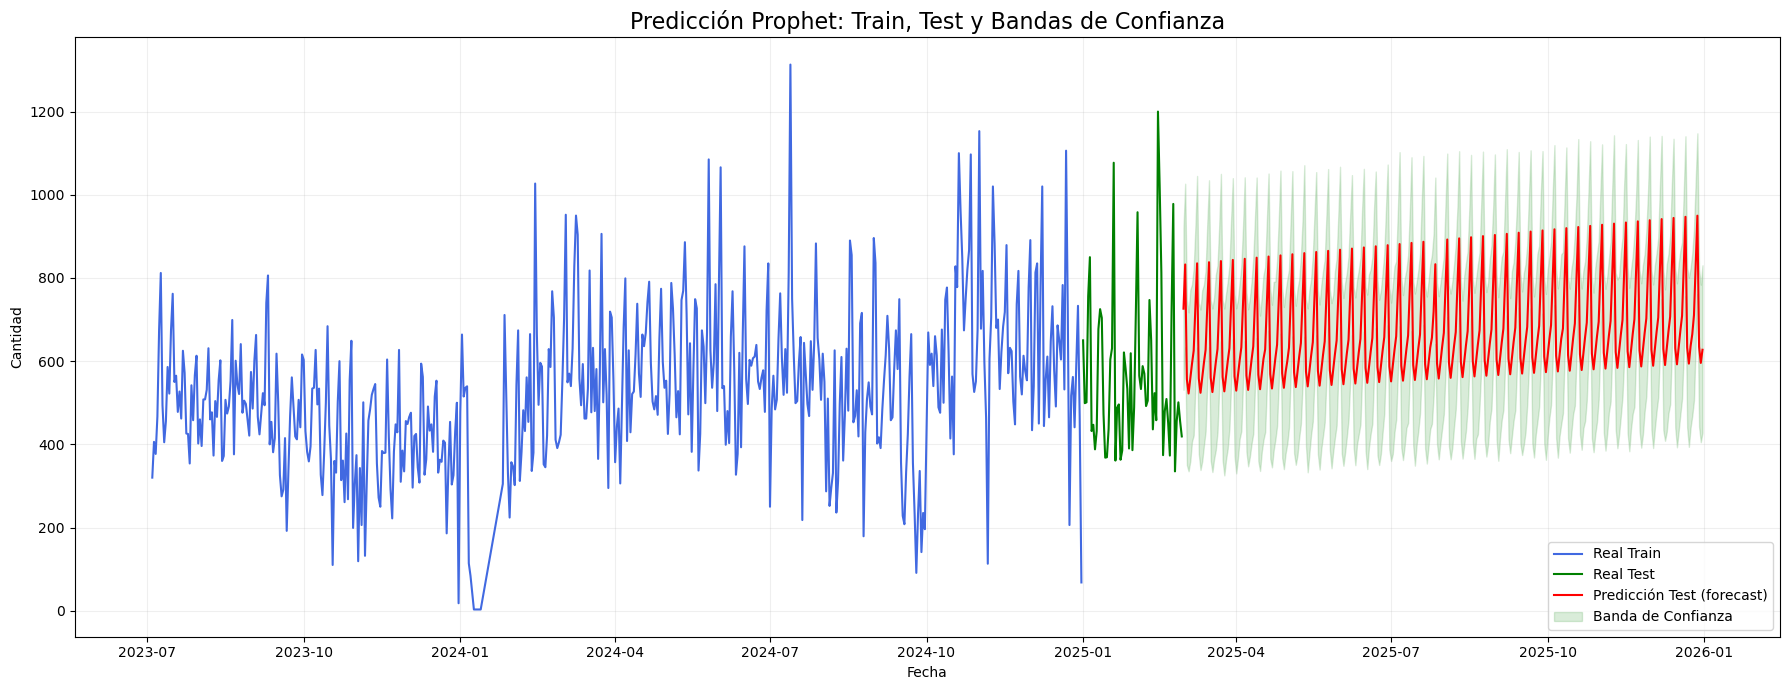

In [62]:
historico_train = train_prophet[['ds', 'y']].copy()
historico_test = test_prophet[['ds', 'y']].copy()
historico = pd.concat([historico_train, historico_test], sort=False)
historico = historico.rename(columns={'y': 'yhat'})
historico['tipo'] = 'Histórico'

# historico_forecast_train = forecast_train[['ds', 'y']].copy()
# historico_forecast_test = forecast_test[['ds', 'y']].copy()
# historico_forescast = pd.concat([historico_forecast_train, historico_forecast_test], sort=False)
# historico_forescast = historico_forescast.rename(columns={'y': 'yhat'})
# historico_forescast['tipo'] = 'Histórico'

forecast_futuro = forecast_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_futuro['tipo'] = 'Forecast'

df_total = pd.concat([historico, forecast_futuro], sort=False)
df_total = df_total.sort_values('ds').reset_index(drop=True)

historico_train = train_prophet[['ds', 'y']].copy()
historico_test = test_prophet[['ds', 'y']].copy()
historico = pd.concat([historico_train, historico_test], sort=False)
historico = historico.rename(columns={'y': 'yhat'})
historico['tipo'] = 'Histórico'


forecast_futuro = forecast_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_futuro['tipo'] = 'Forecast'

df_total = pd.concat([historico, forecast_futuro], sort=False)
df_total = df_total.sort_values('ds').reset_index(drop=True)

# --- Series reales ---
plt.figure(figsize=(18, 7))
plt.plot(historico_train['ds'], historico_train['y'], color='royalblue', label='Real Train')
plt.plot(historico_test['ds'], historico_test['y'], color='green', label='Real Test')

# --- Predicciones ---
plt.plot(forecast_futuro['ds'], forecast_futuro['yhat'], color='red', label='Predicción Test (forecast)')

# # --- Banda de confianza ---
plt.fill_between(forecast_futuro['ds'], forecast_futuro['yhat_lower'], forecast_futuro['yhat_upper'],
                 color='green', alpha=0.15, label='Banda de Confianza')

# --- Estilo y leyenda ---
plt.title('Predicción Prophet: Train, Test y Bandas de Confianza', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.tight_layout()

plt.show()

**Conclusiones**

- El análisis muestra que el modelo Prophet es adecuado para realizar el pronóstico diario de la demanda durante 2025.
- El pronóstico respeta la tendencia y estacionalidad semanal aprendidas de la serie histórica, y comunica de forma realista la incertidumbre de la predicción.
- El forecast para 2025 proyecta un comportamiento estacional, manteniendo la tendencia semanal observada en el histórico.
- Se observa una transición suave entre los últimos datos reales y el inicio de la predicción, lo que indica buena calibración del modelo.
- La banda de confianza se va ampliando a medida que avanza el año 2025, lo que es esperado en pronósticos de largo plazo (más incertidumbre a futuro).
- La amplitud de la banda indica que el modelo considera la variabilidad histórica y transmite adecuadamente la incertidumbre.
- No se observa sobreajuste ni cambios abruptos en el inicio del forecast, lo que valida el ajuste de hiperparámetros realizado.
- El modelo no predice eventos atípicos (outliers o shocks externos). Si en el histórico hay periodos anómalos (como el cierre por reparaciones), Prophet “suaviza” estos efectos y no los proyecta al futuro.


#### **6. Almacenamiento de Dataset de histórico y pronósticos de la demanda.**

In [63]:
df_all = df_total[['ds','yhat']]
df_all.rename(columns={'ds': 'fecha', 'yhat': 'cantidad'}, inplace=True)

df_all.to_csv('./data-sets/data_pronostico_juankys_pan.csv',index=False)

In [64]:
# Almacenando el dataset modificaado en formato Parquet para conservar los tipos de datos.
df_update.to_parquet("./data-sets/data_hitorico_ventas_mod.parquet",  index=False)



In [65]:
df_load = pd.read_parquet('./data-sets/data_hitorico_ventas_mod.parquet')

In [66]:
df_load.to_csv('./data-sets/data_hitorico_ventas_mod.csv',index=False)

#### **7. Proceso de integración de los modelos.**

In [18]:
df_demanda_general  = pd.read_csv('../data-sets/data_pronostico_demanda.csv')

df_demanda_general = df_demanda_general.rename(columns={'cantidad':'general'})

In [14]:
df_batido_helado  = pd.read_csv('../data-sets/data_pronostico_producto_batido_helado.csv')
df_croqueta_jamon  = pd.read_csv('../data-sets/data_pronostico_producto_croquetas_jamon.csv')
df_suero_helado  = pd.read_csv('../data-sets/data_pronostico_producto_suero_helado.csv')

In [20]:
df_forecast_product = pd.merge(df_batido_helado,df_croqueta_jamon, on='fecha')
df_forecast_product = pd.merge(df_forecast_product,df_suero_helado, on='fecha')
df_forecast_product = pd.merge(df_forecast_product,df_demanda_general, on='fecha')

In [24]:
df_forecast_product[df_forecast_product.select_dtypes(include="float").columns] = df_forecast_product.select_dtypes(include="float").round().astype(int)
df_forecast_product

,fecha,batido_helado,es_festivo,es_fin_semana,croquetas_jamon,suero_helado,general
0,2023-07-04,2,0,0,16,19,320
1,2023-07-06,17,0,0,13,45,377
2,2023-07-07,13,0,0,31,52,467
3,2023-07-09,2,0,1,65,68,812
4,2023-07-10,13,0,0,19,43,494
...,...,...,...,...,...,...,...
800,2025-12-27,60,0,1,35,-1,857
801,2025-12-28,60,0,1,44,5,941
802,2025-12-29,27,0,0,27,-6,715
803,2025-12-30,27,0,0,26,-9,689


In [25]:
df_forecast_product.to_csv('../data-sets/data_pronostico_productos_demanda.csv')